In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace


In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_stats_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:

configs.data_name = data_name



In [7]:

pp = "mm-spec" 

if pp == "mm-spec":
    specifier = specifier + "--pp: " + pp

    
    
configs.specifier = specifier



In [8]:

configs.specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

## Load Data

In [9]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [10]:
data_name

'dd_fix_stats_demo'

In [11]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]

elif data_name == "dd_fix_stats_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    fix_stats = dd.get_fix_stats_dataset()  # fixes

    # concatenate pd.dfs to a pd.df
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix_stats = fix_stats.loc[fix_stats.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_stats_demo = dd.concat_dfs(
        df1=fix_stats,
        df2=demo_phono,
        features1=fix_stats.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_stats_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID',
    ]

    targets = ["Group", "Reading_speed", ]

    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report statistics data: (9071, 10)


In [12]:


data_name



'dd_fix_stats_demo'

In [13]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,8,645.693750,283.247212,537.731250,5.683393,147.500000,78.438086,1,4,10,23,102.0
1,1,10,5,8,644.781081,202.020928,524.345946,8.486152,180.810811,88.588574,1,4,10,23,102.0
2,1,10,6,9,708.334615,292.435973,536.546154,7.099140,187.961538,130.054290,1,4,10,23,102.0
3,1,10,7,8,676.047619,317.074279,535.933333,6.465627,179.761905,73.502996,1,4,10,23,102.0
4,1,10,8,8,440.215000,235.935556,541.580000,5.290667,201.800000,91.100638,1,4,10,23,102.0


In [14]:
df_data_to_use.shape

(9071, 15)

In [15]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [16]:

x_org.head()



,Age,Sex_1,Grade_5,FIX_Y_mean,FIX_X_std,FIX_DURATION_std,FIX_X_mean,Word_Number,Sex_2,Grade_4,FIX_Y_std,Grade_2,Grade_1,FIX_DURATION_mean,IQ,Grade_6,Grade_3
0,10,1,0,537.731250,283.247212,78.438086,645.693750,8,0,1,5.683393,0,0,147.500000,23,0,0
1,10,1,0,524.345946,202.020928,88.588574,644.781081,8,0,1,8.486152,0,0,180.810811,23,0,0
2,10,1,0,536.546154,292.435973,130.054290,708.334615,9,0,1,7.099140,0,0,187.961538,23,0,0
3,10,1,0,535.933333,317.074279,73.502996,676.047619,8,0,1,6.465627,0,0,179.761905,23,0,0
4,10,1,0,541.580000,235.935556,91.100638,440.215000,8,0,1,5.290667,0,0,201.800000,23,0,0


In [17]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [18]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [19]:

# x = preprocess_data(x=x_org, pp="mm")  # only x is standardized


# x_df = dd.get_preprocessed_train_test_onehot_features(x_dum=x_org)
# x = x_df.values

x = preprocess_data(x=x_org, pp='mm')  # only x is standardized



pre-processing: mm
Preprocessed data shape: (9071, 17)


In [22]:

x.shape

(9071, 17)

In [23]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )


In [24]:

for k, v in data.items():
    print(k, v['x_train'].shape, v['x_test'].shape,)
    
    

1 (8163, 17) (908, 17)
2 (8164, 17) (907, 17)
3 (8164, 17) (907, 17)
4 (8164, 17) (907, 17)
5 (8164, 17) (907, 17)
6 (8164, 17) (907, 17)
7 (8164, 17) (907, 17)
8 (8164, 17) (907, 17)
9 (8164, 17) (907, 17)
10 (8164, 17) (907, 17)


## Load the tuned parameters

In [25]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 27),
             ('max_iter', 34339),
             ('solver', 'lbfgs')])

In [26]:


specifier



'dd_fix_stats_demo-mlp_cls--shuffled:True--exclude at risk:0--pp: mm-spec'

In [27]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [28]:

n_s = str(6)
x_train = data[n_s]["x_train"]
x_test = data[n_s]["x_test"]
y_train = data[n_s]["y_train"]
y_test = data[n_s]["y_test"]



In [29]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Previously obtained results

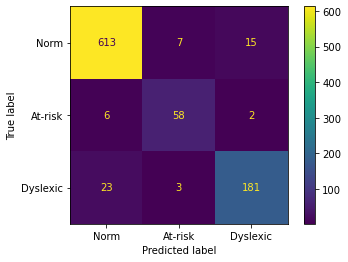

Kappa: 0.8630615102876226 AUC ROC: 0.9834043640479089


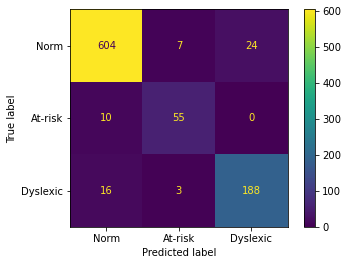

Kappa: 0.8546823680205079 AUC ROC: 0.9807125339457422


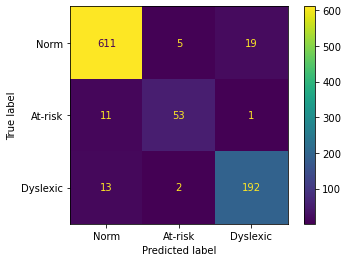

Kappa: 0.8755327736519212 AUC ROC: 0.987638420965078


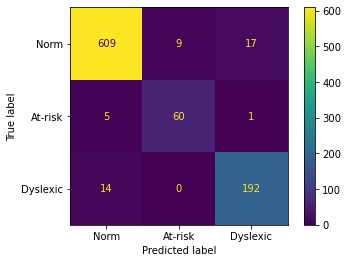

Kappa: 0.8890534629243063 AUC ROC: 0.9863454615183456


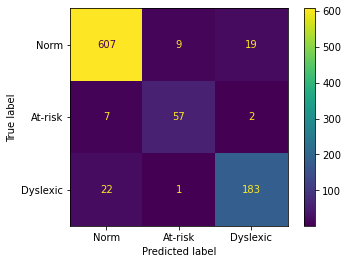

Kappa: 0.8538444391327351 AUC ROC: 0.9823381894225923


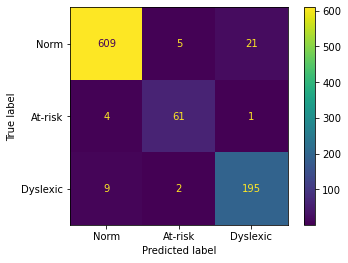

Kappa: 0.8993524250374516 AUC ROC: 0.9893629685916602


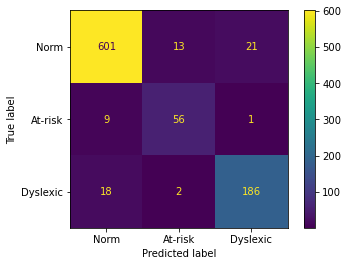

Kappa: 0.8457544475002325 AUC ROC: 0.9825137054319666


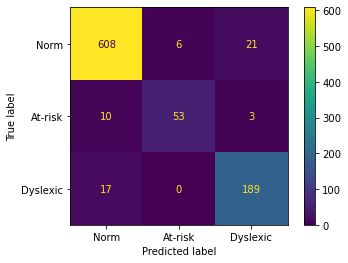

Kappa: 0.8608940621872074 AUC ROC: 0.98330948555894


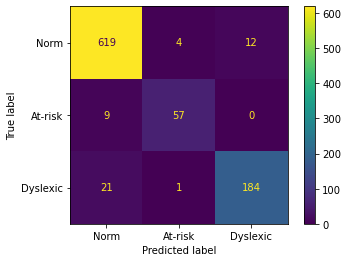

Kappa: 0.8835483218873099 AUC ROC: 0.9884392730119028


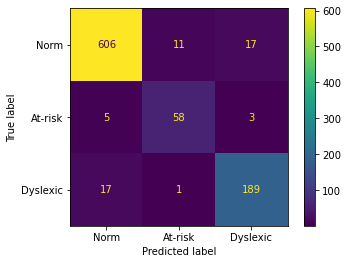

Kappa: 0.869951727763705 AUC ROC: 0.9871912801585697


In [30]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )



for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [31]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.806 0.022 0.690 0.031 0.941 0.007 0.941 0.007 0.941 0.007 0.985 0.003 1.167 0.094 0.088 0.005 0.941 0.007 0.929 0.013


In [32]:


mdl.fit(x_train, y_train)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          570     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61558D+00    |proj g|=  5.06644D-01

At iterate    1    f=  8.48805D-01    |proj g|=  7.28179D-02

At iterate    2    f=  8.20006D-01    |proj g|=  3.64069D-02

At iterate    3    f=  8.03667D-01    |proj g|=  3.83806D-02

At iterate    4    f=  7.63219D-01    |proj g|=  4.52659D-02

At iterate    5    f=  7.32322D-01    |proj g|=  1.54401D-02

At iterate    6    f=  7.24289D-01    |proj g|=  2.33823D-02

At iterate    7    f=  7.11264D-01    |proj g|=  3.11913D-02

At iterate    8    f=  7.06020D-01    |proj g|=  1.07885D-02

At iterate    9    f=  7.02370D-01    |proj g|=  1.32777D-02

At iterate   10    f=  6.97710D-01    |proj g|=  1.33145D-02

At iterate   11    f=  6.79761D-01    |proj g|=  2.23779D-02

At iterate   12    f=  6.77831D-01    |proj g|=  3.06781D-02

At iterate   13    f=  6.6

 This problem is unconstrained.



At iterate   43    f=  5.49156D-01    |proj g|=  1.41518D-02

At iterate   44    f=  5.47750D-01    |proj g|=  8.58593D-03

At iterate   45    f=  5.45927D-01    |proj g|=  1.11676D-02

At iterate   46    f=  5.42926D-01    |proj g|=  1.26438D-02

At iterate   47    f=  5.40120D-01    |proj g|=  1.45650D-02

At iterate   48    f=  5.37664D-01    |proj g|=  2.04543D-02

At iterate   49    f=  5.35556D-01    |proj g|=  2.04826D-02

At iterate   50    f=  5.34413D-01    |proj g|=  9.52610D-03

At iterate   51    f=  5.34045D-01    |proj g|=  1.13067D-02

At iterate   52    f=  5.33012D-01    |proj g|=  1.13920D-02

At iterate   53    f=  5.31648D-01    |proj g|=  9.55388D-03

At iterate   54    f=  5.30470D-01    |proj g|=  2.32497D-02

At iterate   55    f=  5.28183D-01    |proj g|=  1.92022D-02

At iterate   56    f=  5.26722D-01    |proj g|=  6.64434D-03

At iterate   57    f=  5.25155D-01    |proj g|=  9.14733D-03

At iterate   58    f=  5.23641D-01    |proj g|=  8.11952D-03

At iter


At iterate  176    f=  3.92539D-01    |proj g|=  2.35505D-02

At iterate  177    f=  3.91407D-01    |proj g|=  7.61695D-03

At iterate  178    f=  3.90980D-01    |proj g|=  7.18240D-03

At iterate  179    f=  3.90196D-01    |proj g|=  1.35360D-02

At iterate  180    f=  3.88900D-01    |proj g|=  8.93350D-03

At iterate  181    f=  3.88301D-01    |proj g|=  7.90350D-03

At iterate  182    f=  3.87439D-01    |proj g|=  1.19678D-02

At iterate  183    f=  3.86661D-01    |proj g|=  9.48138D-03

At iterate  184    f=  3.86542D-01    |proj g|=  1.86047D-02

At iterate  185    f=  3.85075D-01    |proj g|=  4.80579D-03

At iterate  186    f=  3.84704D-01    |proj g|=  5.30387D-03

At iterate  187    f=  3.83871D-01    |proj g|=  9.10653D-03

At iterate  188    f=  3.82950D-01    |proj g|=  6.58396D-03

At iterate  189    f=  3.82647D-01    |proj g|=  1.50865D-02

At iterate  190    f=  3.81807D-01    |proj g|=  6.17457D-03

At iterate  191    f=  3.81283D-01    |proj g|=  5.21320D-03

At iter

At iterate  318    f=  3.07151D-01    |proj g|=  4.12754D-03

At iterate  319    f=  3.06702D-01    |proj g|=  5.87412D-03

At iterate  320    f=  3.05828D-01    |proj g|=  6.02389D-03

At iterate  321    f=  3.05283D-01    |proj g|=  7.23568D-03

At iterate  322    f=  3.04707D-01    |proj g|=  5.19834D-03

At iterate  323    f=  3.03981D-01    |proj g|=  3.74343D-03

At iterate  324    f=  3.03646D-01    |proj g|=  5.76437D-03

At iterate  325    f=  3.03174D-01    |proj g|=  4.71322D-03

At iterate  326    f=  3.02442D-01    |proj g|=  4.72719D-03

At iterate  327    f=  3.01549D-01    |proj g|=  5.81484D-03

At iterate  328    f=  3.01025D-01    |proj g|=  7.38801D-03

At iterate  329    f=  3.00662D-01    |proj g|=  3.08916D-03

At iterate  330    f=  3.00211D-01    |proj g|=  4.24633D-03

At iterate  331    f=  2.99621D-01    |proj g|=  4.42530D-03

At iterate  332    f=  2.98898D-01    |proj g|=  7.20276D-03

At iterate  333    f=  2.98418D-01    |proj g|=  7.56131D-03

At itera


At iterate  459    f=  2.42587D-01    |proj g|=  5.44118D-03

At iterate  460    f=  2.42429D-01    |proj g|=  4.47059D-03

At iterate  461    f=  2.42187D-01    |proj g|=  2.69242D-03

At iterate  462    f=  2.41867D-01    |proj g|=  2.87886D-03

At iterate  463    f=  2.41283D-01    |proj g|=  3.38189D-03

At iterate  464    f=  2.41024D-01    |proj g|=  6.98244D-03

At iterate  465    f=  2.40606D-01    |proj g|=  4.28134D-03

At iterate  466    f=  2.40213D-01    |proj g|=  2.55079D-03

At iterate  467    f=  2.39975D-01    |proj g|=  7.02699D-03

At iterate  468    f=  2.39710D-01    |proj g|=  2.67229D-03

At iterate  469    f=  2.39473D-01    |proj g|=  2.39096D-03

At iterate  470    f=  2.39227D-01    |proj g|=  4.14157D-03

At iterate  471    f=  2.38717D-01    |proj g|=  6.65625D-03

At iterate  472    f=  2.38372D-01    |proj g|=  7.44824D-03

At iterate  473    f=  2.37815D-01    |proj g|=  3.58156D-03

At iterate  474    f=  2.37447D-01    |proj g|=  3.74531D-03

At iter


At iterate  596    f=  2.10071D-01    |proj g|=  2.59547D-03

At iterate  597    f=  2.09908D-01    |proj g|=  7.92322D-03

At iterate  598    f=  2.09667D-01    |proj g|=  3.34762D-03

At iterate  599    f=  2.09418D-01    |proj g|=  2.34679D-03

At iterate  600    f=  2.09165D-01    |proj g|=  2.69395D-03

At iterate  601    f=  2.08943D-01    |proj g|=  1.04807D-02

At iterate  602    f=  2.08656D-01    |proj g|=  1.93340D-03

At iterate  603    f=  2.08552D-01    |proj g|=  1.78617D-03

At iterate  604    f=  2.08429D-01    |proj g|=  3.10104D-03

At iterate  605    f=  2.08385D-01    |proj g|=  1.01336D-02

At iterate  606    f=  2.08216D-01    |proj g|=  2.70167D-03

At iterate  607    f=  2.08104D-01    |proj g|=  1.76401D-03

At iterate  608    f=  2.07984D-01    |proj g|=  2.45984D-03

At iterate  609    f=  2.07803D-01    |proj g|=  2.47927D-03

At iterate  610    f=  2.07649D-01    |proj g|=  8.80305D-03

At iterate  611    f=  2.07400D-01    |proj g|=  3.38495D-03

At iter


At iterate  733    f=  1.85875D-01    |proj g|=  6.38495D-03

At iterate  734    f=  1.85716D-01    |proj g|=  2.75686D-03

At iterate  735    f=  1.85602D-01    |proj g|=  2.00787D-03

At iterate  736    f=  1.85483D-01    |proj g|=  2.07568D-03

At iterate  737    f=  1.85337D-01    |proj g|=  2.80944D-03

At iterate  738    f=  1.85258D-01    |proj g|=  3.63194D-03

At iterate  739    f=  1.85153D-01    |proj g|=  1.61637D-03

At iterate  740    f=  1.85077D-01    |proj g|=  1.39145D-03

At iterate  741    f=  1.84948D-01    |proj g|=  2.34420D-03

At iterate  742    f=  1.84872D-01    |proj g|=  4.70780D-03

At iterate  743    f=  1.84746D-01    |proj g|=  2.78094D-03

At iterate  744    f=  1.84513D-01    |proj g|=  2.15745D-03

At iterate  745    f=  1.84344D-01    |proj g|=  2.06080D-03

At iterate  746    f=  1.84270D-01    |proj g|=  6.26876D-03

At iterate  747    f=  1.84084D-01    |proj g|=  3.55314D-03

At iterate  748    f=  1.83899D-01    |proj g|=  1.98147D-03

At iter


At iterate  889    f=  1.67990D-01    |proj g|=  6.54691D-03

At iterate  890    f=  1.67890D-01    |proj g|=  3.50943D-03

At iterate  891    f=  1.67809D-01    |proj g|=  2.57878D-03

At iterate  892    f=  1.67695D-01    |proj g|=  2.73676D-03

At iterate  893    f=  1.67592D-01    |proj g|=  2.98529D-03

At iterate  894    f=  1.67269D-01    |proj g|=  2.86535D-03

At iterate  895    f=  1.67190D-01    |proj g|=  5.85961D-03

At iterate  896    f=  1.67033D-01    |proj g|=  1.92777D-03

At iterate  897    f=  1.66913D-01    |proj g|=  2.21222D-03

At iterate  898    f=  1.66853D-01    |proj g|=  6.57334D-03

At iterate  899    f=  1.66766D-01    |proj g|=  3.41141D-03

At iterate  900    f=  1.66644D-01    |proj g|=  1.54680D-03

At iterate  901    f=  1.66557D-01    |proj g|=  4.96044D-03

At iterate  902    f=  1.66487D-01    |proj g|=  7.48838D-03

At iterate  903    f=  1.66411D-01    |proj g|=  3.49686D-03

At iterate  904    f=  1.66308D-01    |proj g|=  1.84162D-03

At iter


At iterate 1030    f=  1.56528D-01    |proj g|=  4.02067D-03

At iterate 1031    f=  1.56477D-01    |proj g|=  1.74878D-03

At iterate 1032    f=  1.56443D-01    |proj g|=  2.75450D-03

At iterate 1033    f=  1.56387D-01    |proj g|=  5.95098D-03

At iterate 1034    f=  1.56302D-01    |proj g|=  3.55448D-03

At iterate 1035    f=  1.56223D-01    |proj g|=  1.93796D-03

At iterate 1036    f=  1.56145D-01    |proj g|=  1.95997D-03

At iterate 1037    f=  1.56090D-01    |proj g|=  5.29158D-03

At iterate 1038    f=  1.56031D-01    |proj g|=  1.97478D-03

At iterate 1039    f=  1.55978D-01    |proj g|=  1.16584D-03

At iterate 1040    f=  1.55943D-01    |proj g|=  1.63134D-03

At iterate 1041    f=  1.55858D-01    |proj g|=  9.89973D-03

At iterate 1042    f=  1.55750D-01    |proj g|=  2.27579D-03

At iterate 1043    f=  1.55676D-01    |proj g|=  2.09631D-03

At iterate 1044    f=  1.55596D-01    |proj g|=  2.23460D-03

At iterate 1045    f=  1.55491D-01    |proj g|=  9.65124D-03

At iter


At iterate 1185    f=  1.46819D-01    |proj g|=  1.25773D-03

At iterate 1186    f=  1.46757D-01    |proj g|=  1.93908D-03

At iterate 1187    f=  1.46732D-01    |proj g|=  5.42781D-03

At iterate 1188    f=  1.46688D-01    |proj g|=  3.01851D-03

At iterate 1189    f=  1.46634D-01    |proj g|=  1.37852D-03

At iterate 1190    f=  1.46586D-01    |proj g|=  1.72160D-03

At iterate 1191    f=  1.46508D-01    |proj g|=  2.82813D-03

At iterate 1192    f=  1.46488D-01    |proj g|=  8.85202D-03

At iterate 1193    f=  1.46376D-01    |proj g|=  1.45396D-03

At iterate 1194    f=  1.46344D-01    |proj g|=  1.80082D-03

At iterate 1195    f=  1.46281D-01    |proj g|=  1.92516D-03

At iterate 1196    f=  1.46247D-01    |proj g|=  1.21870D-02

At iterate 1197    f=  1.46151D-01    |proj g|=  2.33251D-03

At iterate 1198    f=  1.46106D-01    |proj g|=  1.77588D-03

At iterate 1199    f=  1.46056D-01    |proj g|=  1.74629D-03

At iterate 1200    f=  1.46040D-01    |proj g|=  4.63451D-03

At iter


At iterate 1322    f=  1.41255D-01    |proj g|=  6.10652D-03

At iterate 1323    f=  1.41205D-01    |proj g|=  2.68629D-03

At iterate 1324    f=  1.41180D-01    |proj g|=  2.84630D-03

At iterate 1325    f=  1.41150D-01    |proj g|=  2.63727D-03

At iterate 1326    f=  1.41122D-01    |proj g|=  2.42359D-03

At iterate 1327    f=  1.41058D-01    |proj g|=  3.19783D-03

At iterate 1328    f=  1.41012D-01    |proj g|=  1.35278D-03

At iterate 1329    f=  1.40981D-01    |proj g|=  1.76792D-03

At iterate 1330    f=  1.40941D-01    |proj g|=  1.90251D-03

At iterate 1331    f=  1.40918D-01    |proj g|=  4.44035D-03

At iterate 1332    f=  1.40884D-01    |proj g|=  2.33112D-03

At iterate 1333    f=  1.40849D-01    |proj g|=  1.61948D-03

At iterate 1334    f=  1.40827D-01    |proj g|=  2.28275D-03

At iterate 1335    f=  1.40792D-01    |proj g|=  4.30318D-03

At iterate 1336    f=  1.40772D-01    |proj g|=  5.75736D-03

At iterate 1337    f=  1.40740D-01    |proj g|=  1.45656D-03

At iter


At iterate 1463    f=  1.37347D-01    |proj g|=  2.64970D-03

At iterate 1464    f=  1.37318D-01    |proj g|=  5.74509D-03

At iterate 1465    f=  1.37281D-01    |proj g|=  3.43809D-03

At iterate 1466    f=  1.37237D-01    |proj g|=  2.34297D-03

At iterate 1467    f=  1.37198D-01    |proj g|=  1.56950D-03

At iterate 1468    f=  1.37155D-01    |proj g|=  2.15627D-03

At iterate 1469    f=  1.37140D-01    |proj g|=  4.47637D-03

At iterate 1470    f=  1.37100D-01    |proj g|=  2.71030D-03

At iterate 1471    f=  1.37059D-01    |proj g|=  2.05297D-03

At iterate 1472    f=  1.37017D-01    |proj g|=  2.19156D-03

At iterate 1473    f=  1.36973D-01    |proj g|=  2.82109D-03

At iterate 1474    f=  1.36952D-01    |proj g|=  3.45526D-03

At iterate 1475    f=  1.36917D-01    |proj g|=  1.58195D-03

At iterate 1476    f=  1.36886D-01    |proj g|=  1.31441D-03

At iterate 1477    f=  1.36844D-01    |proj g|=  4.16371D-03

At iterate 1478    f=  1.36802D-01    |proj g|=  2.89087D-03

At iter


At iterate 1609    f=  1.32984D-01    |proj g|=  4.64089D-03

At iterate 1610    f=  1.32961D-01    |proj g|=  2.69668D-03

At iterate 1611    f=  1.32932D-01    |proj g|=  1.40762D-03

At iterate 1612    f=  1.32912D-01    |proj g|=  2.00626D-03

At iterate 1613    f=  1.32863D-01    |proj g|=  2.51406D-03

At iterate 1614    f=  1.32851D-01    |proj g|=  2.74994D-03

At iterate 1615    f=  1.32822D-01    |proj g|=  1.66368D-03

At iterate 1616    f=  1.32798D-01    |proj g|=  1.14888D-03

At iterate 1617    f=  1.32763D-01    |proj g|=  1.25536D-03

At iterate 1618    f=  1.32727D-01    |proj g|=  1.61324D-03

At iterate 1619    f=  1.32712D-01    |proj g|=  3.04521D-03

At iterate 1620    f=  1.32686D-01    |proj g|=  1.23491D-03

At iterate 1621    f=  1.32672D-01    |proj g|=  3.63909D-03

At iterate 1622    f=  1.32658D-01    |proj g|=  2.24433D-03

At iterate 1623    f=  1.32637D-01    |proj g|=  1.66437D-03

At iterate 1624    f=  1.32598D-01    |proj g|=  2.01494D-03

At iter


At iterate 1763    f=  1.29638D-01    |proj g|=  2.06314D-03

At iterate 1764    f=  1.29626D-01    |proj g|=  8.45309D-04

At iterate 1765    f=  1.29614D-01    |proj g|=  1.44097D-03

At iterate 1766    f=  1.29600D-01    |proj g|=  3.30157D-03

At iterate 1767    f=  1.29580D-01    |proj g|=  2.19801D-03

At iterate 1768    f=  1.29553D-01    |proj g|=  1.69905D-03

At iterate 1769    f=  1.29522D-01    |proj g|=  1.38626D-03

At iterate 1770    f=  1.29493D-01    |proj g|=  1.87512D-03

At iterate 1771    f=  1.29461D-01    |proj g|=  2.61691D-03

At iterate 1772    f=  1.29454D-01    |proj g|=  6.45788D-03

At iterate 1773    f=  1.29413D-01    |proj g|=  1.20782D-03

At iterate 1774    f=  1.29404D-01    |proj g|=  8.52846D-04

At iterate 1775    f=  1.29395D-01    |proj g|=  1.02213D-03

At iterate 1776    f=  1.29384D-01    |proj g|=  4.69736D-03

At iterate 1777    f=  1.29361D-01    |proj g|=  2.15015D-03

At iterate 1778    f=  1.29338D-01    |proj g|=  9.89812D-04

At iter


At iterate 1903    f=  1.26399D-01    |proj g|=  1.64350D-03

At iterate 1904    f=  1.26369D-01    |proj g|=  1.87723D-03

At iterate 1905    f=  1.26359D-01    |proj g|=  2.18112D-03

At iterate 1906    f=  1.26346D-01    |proj g|=  1.02146D-03

At iterate 1907    f=  1.26336D-01    |proj g|=  8.83859D-04

At iterate 1908    f=  1.26311D-01    |proj g|=  1.08790D-03

At iterate 1909    f=  1.26289D-01    |proj g|=  5.21574D-03

At iterate 1910    f=  1.26256D-01    |proj g|=  1.41007D-03

At iterate 1911    f=  1.26235D-01    |proj g|=  1.53721D-03

At iterate 1912    f=  1.26198D-01    |proj g|=  1.76351D-03

At iterate 1913    f=  1.26178D-01    |proj g|=  3.37034D-03

At iterate 1914    f=  1.26156D-01    |proj g|=  1.35755D-03

At iterate 1915    f=  1.26136D-01    |proj g|=  1.20786D-03

At iterate 1916    f=  1.26124D-01    |proj g|=  2.32773D-03

At iterate 1917    f=  1.26111D-01    |proj g|=  2.01105D-03

At iterate 1918    f=  1.26095D-01    |proj g|=  2.35086D-03

At iter


At iterate 2048    f=  1.23654D-01    |proj g|=  1.11052D-03

At iterate 2049    f=  1.23646D-01    |proj g|=  1.53487D-03

At iterate 2050    f=  1.23627D-01    |proj g|=  2.01777D-03

At iterate 2051    f=  1.23614D-01    |proj g|=  2.60100D-03

At iterate 2052    f=  1.23599D-01    |proj g|=  1.41142D-03

At iterate 2053    f=  1.23588D-01    |proj g|=  1.18185D-03

At iterate 2054    f=  1.23581D-01    |proj g|=  3.22703D-03

At iterate 2055    f=  1.23571D-01    |proj g|=  2.31108D-03

At iterate 2056    f=  1.23547D-01    |proj g|=  1.23179D-03

At iterate 2057    f=  1.23532D-01    |proj g|=  8.49402D-04

At iterate 2058    f=  1.23515D-01    |proj g|=  1.20587D-03

At iterate 2059    f=  1.23495D-01    |proj g|=  1.70328D-03

At iterate 2060    f=  1.23471D-01    |proj g|=  2.23226D-03

At iterate 2061    f=  1.23451D-01    |proj g|=  8.24483D-04

At iterate 2062    f=  1.23431D-01    |proj g|=  1.28594D-03

At iterate 2063    f=  1.23423D-01    |proj g|=  4.25578D-03

At iter


At iterate 2187    f=  1.21702D-01    |proj g|=  1.42202D-03

At iterate 2188    f=  1.21687D-01    |proj g|=  1.46841D-03

At iterate 2189    f=  1.21680D-01    |proj g|=  1.75711D-03

At iterate 2190    f=  1.21668D-01    |proj g|=  7.41395D-04

At iterate 2191    f=  1.21658D-01    |proj g|=  9.82661D-04

At iterate 2192    f=  1.21649D-01    |proj g|=  5.27750D-03

At iterate 2193    f=  1.21628D-01    |proj g|=  2.57772D-03

At iterate 2194    f=  1.21613D-01    |proj g|=  1.05689D-03

At iterate 2195    f=  1.21601D-01    |proj g|=  1.40813D-03

At iterate 2196    f=  1.21582D-01    |proj g|=  1.64157D-03

At iterate 2197    f=  1.21572D-01    |proj g|=  2.89904D-03

At iterate 2198    f=  1.21557D-01    |proj g|=  9.71971D-04

At iterate 2199    f=  1.21547D-01    |proj g|=  1.37522D-03

At iterate 2200    f=  1.21533D-01    |proj g|=  2.00011D-03

At iterate 2201    f=  1.21520D-01    |proj g|=  1.38084D-03

At iterate 2202    f=  1.21504D-01    |proj g|=  1.16938D-03

At iter


At iterate 2339    f=  1.20165D-01    |proj g|=  1.44123D-03

At iterate 2340    f=  1.20159D-01    |proj g|=  7.19855D-04

At iterate 2341    f=  1.20153D-01    |proj g|=  8.62181D-04

At iterate 2342    f=  1.20147D-01    |proj g|=  1.04774D-03

At iterate 2343    f=  1.20144D-01    |proj g|=  2.13382D-03

At iterate 2344    f=  1.20136D-01    |proj g|=  9.25861D-04

At iterate 2345    f=  1.20129D-01    |proj g|=  5.55589D-04

At iterate 2346    f=  1.20124D-01    |proj g|=  6.65477D-04

At iterate 2347    f=  1.20117D-01    |proj g|=  1.69154D-03

At iterate 2348    f=  1.20110D-01    |proj g|=  8.63860D-04

At iterate 2349    f=  1.20104D-01    |proj g|=  6.17790D-04

At iterate 2350    f=  1.20094D-01    |proj g|=  6.63900D-04

At iterate 2351    f=  1.20087D-01    |proj g|=  1.27112D-03

At iterate 2352    f=  1.20080D-01    |proj g|=  1.59109D-03

At iterate 2353    f=  1.20072D-01    |proj g|=  6.10135D-04

At iterate 2354    f=  1.20062D-01    |proj g|=  1.05828D-03

At iter


At iterate 2475    f=  1.18824D-01    |proj g|=  1.95811D-03

At iterate 2476    f=  1.18808D-01    |proj g|=  2.36517D-03

At iterate 2477    f=  1.18803D-01    |proj g|=  2.81316D-03

At iterate 2478    f=  1.18791D-01    |proj g|=  1.30714D-03

At iterate 2479    f=  1.18785D-01    |proj g|=  6.73508D-04

At iterate 2480    f=  1.18778D-01    |proj g|=  1.03487D-03

At iterate 2481    f=  1.18774D-01    |proj g|=  2.40026D-03

At iterate 2482    f=  1.18769D-01    |proj g|=  1.16226D-03

At iterate 2483    f=  1.18764D-01    |proj g|=  8.58643D-04

At iterate 2484    f=  1.18759D-01    |proj g|=  8.95608D-04

At iterate 2485    f=  1.18748D-01    |proj g|=  1.67767D-03

At iterate 2486    f=  1.18742D-01    |proj g|=  1.87034D-03

At iterate 2487    f=  1.18734D-01    |proj g|=  1.24776D-03

At iterate 2488    f=  1.18726D-01    |proj g|=  9.99463D-04

At iterate 2489    f=  1.18715D-01    |proj g|=  1.98535D-03

At iterate 2490    f=  1.18712D-01    |proj g|=  3.58745D-03

At iter


At iterate 2626    f=  1.17103D-01    |proj g|=  2.06121D-03

At iterate 2627    f=  1.17087D-01    |proj g|=  2.66660D-03

At iterate 2628    f=  1.17065D-01    |proj g|=  1.17238D-03

At iterate 2629    f=  1.17048D-01    |proj g|=  1.66077D-03

At iterate 2630    f=  1.17035D-01    |proj g|=  9.54209D-04

At iterate 2631    f=  1.17020D-01    |proj g|=  1.06614D-03

At iterate 2632    f=  1.16991D-01    |proj g|=  1.94323D-03

At iterate 2633    f=  1.16982D-01    |proj g|=  3.47304D-03

At iterate 2634    f=  1.16965D-01    |proj g|=  9.40468D-04

At iterate 2635    f=  1.16958D-01    |proj g|=  8.81922D-04

At iterate 2636    f=  1.16949D-01    |proj g|=  2.01942D-03

At iterate 2637    f=  1.16937D-01    |proj g|=  1.38821D-03

At iterate 2638    f=  1.16923D-01    |proj g|=  1.07889D-03

At iterate 2639    f=  1.16903D-01    |proj g|=  1.17262D-03

At iterate 2640    f=  1.16894D-01    |proj g|=  2.23400D-03

At iterate 2641    f=  1.16883D-01    |proj g|=  9.21910D-04

At iter


At iterate 2765    f=  1.15685D-01    |proj g|=  6.29971D-04

At iterate 2766    f=  1.15679D-01    |proj g|=  7.44551D-04

At iterate 2767    f=  1.15673D-01    |proj g|=  1.96907D-03

At iterate 2768    f=  1.15664D-01    |proj g|=  1.16384D-03

At iterate 2769    f=  1.15659D-01    |proj g|=  8.14004D-04

At iterate 2770    f=  1.15654D-01    |proj g|=  7.14392D-04

At iterate 2771    f=  1.15646D-01    |proj g|=  1.70750D-03

At iterate 2772    f=  1.15643D-01    |proj g|=  2.65205D-03

At iterate 2773    f=  1.15635D-01    |proj g|=  6.04141D-04

At iterate 2774    f=  1.15632D-01    |proj g|=  6.32237D-04

At iterate 2775    f=  1.15627D-01    |proj g|=  7.77918D-04

At iterate 2776    f=  1.15616D-01    |proj g|=  1.04724D-03

At iterate 2777    f=  1.15613D-01    |proj g|=  2.07193D-03

At iterate 2778    f=  1.15603D-01    |proj g|=  1.01700D-03

At iterate 2779    f=  1.15594D-01    |proj g|=  7.51280D-04

At iterate 2780    f=  1.15584D-01    |proj g|=  8.62722D-04

At iter


At iterate 2905    f=  1.14651D-01    |proj g|=  2.35396D-03

At iterate 2906    f=  1.14643D-01    |proj g|=  1.15748D-03

At iterate 2907    f=  1.14633D-01    |proj g|=  9.39356D-04

At iterate 2908    f=  1.14627D-01    |proj g|=  1.43521D-03

At iterate 2909    f=  1.14613D-01    |proj g|=  1.55063D-03

At iterate 2910    f=  1.14607D-01    |proj g|=  1.85184D-03

At iterate 2911    f=  1.14597D-01    |proj g|=  1.00277D-03

At iterate 2912    f=  1.14590D-01    |proj g|=  7.76995D-04

At iterate 2913    f=  1.14585D-01    |proj g|=  9.47247D-04

At iterate 2914    f=  1.14583D-01    |proj g|=  3.39733D-03

At iterate 2915    f=  1.14575D-01    |proj g|=  1.25569D-03

At iterate 2916    f=  1.14569D-01    |proj g|=  8.89498D-04

At iterate 2917    f=  1.14564D-01    |proj g|=  1.03837D-03

At iterate 2918    f=  1.14557D-01    |proj g|=  1.17745D-03

At iterate 2919    f=  1.14552D-01    |proj g|=  1.83361D-03

At iterate 2920    f=  1.14545D-01    |proj g|=  9.60478D-04

At iter


At iterate 3039    f=  1.13497D-01    |proj g|=  9.44696D-04

At iterate 3040    f=  1.13479D-01    |proj g|=  9.80681D-04

At iterate 3041    f=  1.13475D-01    |proj g|=  2.30580D-03

At iterate 3042    f=  1.13463D-01    |proj g|=  1.28941D-03

At iterate 3043    f=  1.13449D-01    |proj g|=  8.22078D-04

At iterate 3044    f=  1.13431D-01    |proj g|=  2.33129D-03

At iterate 3045    f=  1.13416D-01    |proj g|=  2.69251D-03

At iterate 3046    f=  1.13402D-01    |proj g|=  1.84609D-03

At iterate 3047    f=  1.13392D-01    |proj g|=  1.35078D-03

At iterate 3048    f=  1.13385D-01    |proj g|=  1.23565D-03

At iterate 3049    f=  1.13378D-01    |proj g|=  2.15683D-03

At iterate 3050    f=  1.13368D-01    |proj g|=  1.64319D-03

At iterate 3051    f=  1.13325D-01    |proj g|=  1.38400D-03

At iterate 3052    f=  1.13313D-01    |proj g|=  2.89294D-03

At iterate 3053    f=  1.13294D-01    |proj g|=  1.42494D-03

At iterate 3054    f=  1.13276D-01    |proj g|=  9.27803D-04

At iter


At iterate 3174    f=  1.11580D-01    |proj g|=  1.89084D-03

At iterate 3175    f=  1.11562D-01    |proj g|=  3.11832D-03

At iterate 3176    f=  1.11546D-01    |proj g|=  2.15720D-03

At iterate 3177    f=  1.11533D-01    |proj g|=  1.07213D-03

At iterate 3178    f=  1.11520D-01    |proj g|=  1.30245D-03

At iterate 3179    f=  1.11508D-01    |proj g|=  1.90034D-03

At iterate 3180    f=  1.11484D-01    |proj g|=  3.69180D-03

At iterate 3181    f=  1.11465D-01    |proj g|=  1.51343D-03

At iterate 3182    f=  1.11455D-01    |proj g|=  1.36741D-03

At iterate 3183    f=  1.11444D-01    |proj g|=  1.51996D-03

At iterate 3184    f=  1.11434D-01    |proj g|=  1.88447D-03

At iterate 3185    f=  1.11418D-01    |proj g|=  5.06483D-03

At iterate 3186    f=  1.11400D-01    |proj g|=  1.34099D-03

At iterate 3187    f=  1.11391D-01    |proj g|=  1.09581D-03

At iterate 3188    f=  1.11379D-01    |proj g|=  1.24362D-03

At iterate 3189    f=  1.11365D-01    |proj g|=  2.15387D-03

At iter


At iterate 3312    f=  1.09808D-01    |proj g|=  9.18425D-04

At iterate 3313    f=  1.09797D-01    |proj g|=  1.13749D-03

At iterate 3314    f=  1.09786D-01    |proj g|=  6.88458D-04

At iterate 3315    f=  1.09772D-01    |proj g|=  7.53025D-04

At iterate 3316    f=  1.09763D-01    |proj g|=  3.68875D-03

At iterate 3317    f=  1.09746D-01    |proj g|=  9.55568D-04

At iterate 3318    f=  1.09737D-01    |proj g|=  7.38111D-04

At iterate 3319    f=  1.09726D-01    |proj g|=  7.84069D-04

At iterate 3320    f=  1.09718D-01    |proj g|=  2.13122D-03

At iterate 3321    f=  1.09709D-01    |proj g|=  1.22477D-03

At iterate 3322    f=  1.09701D-01    |proj g|=  7.57338D-04

At iterate 3323    f=  1.09695D-01    |proj g|=  1.49989D-03

At iterate 3324    f=  1.09689D-01    |proj g|=  9.99501D-04

At iterate 3325    f=  1.09679D-01    |proj g|=  9.91324D-04

At iterate 3326    f=  1.09668D-01    |proj g|=  1.34487D-03

At iterate 3327    f=  1.09658D-01    |proj g|=  1.94106D-03

At iter


At iterate 3452    f=  1.08620D-01    |proj g|=  1.44350D-03

At iterate 3453    f=  1.08616D-01    |proj g|=  3.45890D-03

At iterate 3454    f=  1.08609D-01    |proj g|=  1.63261D-03

At iterate 3455    f=  1.08603D-01    |proj g|=  7.45616D-04

At iterate 3456    f=  1.08600D-01    |proj g|=  1.03126D-03

At iterate 3457    f=  1.08592D-01    |proj g|=  1.33499D-03

At iterate 3458    f=  1.08588D-01    |proj g|=  2.82573D-03

At iterate 3459    f=  1.08580D-01    |proj g|=  1.81413D-03

At iterate 3460    f=  1.08573D-01    |proj g|=  1.02625D-03

At iterate 3461    f=  1.08566D-01    |proj g|=  1.29023D-03

At iterate 3462    f=  1.08559D-01    |proj g|=  1.63885D-03

At iterate 3463    f=  1.08550D-01    |proj g|=  1.97917D-03

At iterate 3464    f=  1.08542D-01    |proj g|=  9.46263D-04

At iterate 3465    f=  1.08535D-01    |proj g|=  1.79513D-03

At iterate 3466    f=  1.08532D-01    |proj g|=  9.32419D-04

At iterate 3467    f=  1.08530D-01    |proj g|=  7.50297D-04

At iter


At iterate 3588    f=  1.07929D-01    |proj g|=  1.54437D-03

At iterate 3589    f=  1.07923D-01    |proj g|=  5.92651D-04

At iterate 3590    f=  1.07917D-01    |proj g|=  7.86947D-04

At iterate 3591    f=  1.07910D-01    |proj g|=  1.86618D-03

At iterate 3592    f=  1.07901D-01    |proj g|=  1.20939D-03

At iterate 3593    f=  1.07896D-01    |proj g|=  3.01472D-03

At iterate 3594    f=  1.07889D-01    |proj g|=  6.48676D-04

At iterate 3595    f=  1.07886D-01    |proj g|=  7.94950D-04

At iterate 3596    f=  1.07883D-01    |proj g|=  1.68324D-03

At iterate 3597    f=  1.07879D-01    |proj g|=  7.88094D-04

At iterate 3598    f=  1.07876D-01    |proj g|=  4.71054D-04

At iterate 3599    f=  1.07873D-01    |proj g|=  4.74540D-04

At iterate 3600    f=  1.07867D-01    |proj g|=  8.19261D-04

At iterate 3601    f=  1.07859D-01    |proj g|=  2.62395D-03

At iterate 3602    f=  1.07847D-01    |proj g|=  1.17415D-03

At iterate 3603    f=  1.07838D-01    |proj g|=  8.09403D-04

At iter


At iterate 3735    f=  1.07149D-01    |proj g|=  1.32921D-03

At iterate 3736    f=  1.07144D-01    |proj g|=  8.81008D-04

At iterate 3737    f=  1.07139D-01    |proj g|=  6.91113D-04

At iterate 3738    f=  1.07136D-01    |proj g|=  1.02063D-03

At iterate 3739    f=  1.07134D-01    |proj g|=  1.63873D-03

At iterate 3740    f=  1.07132D-01    |proj g|=  1.08289D-03

At iterate 3741    f=  1.07128D-01    |proj g|=  4.15957D-04

At iterate 3742    f=  1.07125D-01    |proj g|=  4.97898D-04

At iterate 3743    f=  1.07122D-01    |proj g|=  1.02695D-03

At iterate 3744    f=  1.07118D-01    |proj g|=  2.05485D-03

At iterate 3745    f=  1.07114D-01    |proj g|=  5.98465D-04

At iterate 3746    f=  1.07111D-01    |proj g|=  6.82291D-04

At iterate 3747    f=  1.07107D-01    |proj g|=  8.23044D-04

At iterate 3748    f=  1.07105D-01    |proj g|=  1.64836D-03

At iterate 3749    f=  1.07100D-01    |proj g|=  8.66960D-04

At iterate 3750    f=  1.07095D-01    |proj g|=  4.79350D-04

At iter


At iterate 3869    f=  1.06491D-01    |proj g|=  9.53513D-04

At iterate 3870    f=  1.06482D-01    |proj g|=  2.38506D-03

At iterate 3871    f=  1.06473D-01    |proj g|=  1.87245D-03

At iterate 3872    f=  1.06466D-01    |proj g|=  1.54785D-03

At iterate 3873    f=  1.06458D-01    |proj g|=  2.26008D-03

At iterate 3874    f=  1.06452D-01    |proj g|=  2.34635D-03

At iterate 3875    f=  1.06447D-01    |proj g|=  1.25343D-03

At iterate 3876    f=  1.06441D-01    |proj g|=  1.06168D-03

At iterate 3877    f=  1.06437D-01    |proj g|=  9.03090D-04

At iterate 3878    f=  1.06426D-01    |proj g|=  1.13011D-03

At iterate 3879    f=  1.06420D-01    |proj g|=  2.32984D-03

At iterate 3880    f=  1.06410D-01    |proj g|=  1.00447D-03

At iterate 3881    f=  1.06401D-01    |proj g|=  8.50061D-04

At iterate 3882    f=  1.06392D-01    |proj g|=  2.19932D-03

At iterate 3883    f=  1.06384D-01    |proj g|=  1.24285D-03

At iterate 3884    f=  1.06371D-01    |proj g|=  1.27297D-03

At iter


At iterate 4012    f=  1.05244D-01    |proj g|=  9.25181D-04

At iterate 4013    f=  1.05235D-01    |proj g|=  8.42296D-04

At iterate 4014    f=  1.05219D-01    |proj g|=  2.16543D-03

At iterate 4015    f=  1.05210D-01    |proj g|=  1.52623D-03

At iterate 4016    f=  1.05203D-01    |proj g|=  8.30162D-04

At iterate 4017    f=  1.05194D-01    |proj g|=  1.98732D-03

At iterate 4018    f=  1.05187D-01    |proj g|=  1.63931D-03

At iterate 4019    f=  1.05179D-01    |proj g|=  1.52611D-03

At iterate 4020    f=  1.05154D-01    |proj g|=  3.15453D-03

At iterate 4021    f=  1.05138D-01    |proj g|=  1.49593D-03

At iterate 4022    f=  1.05133D-01    |proj g|=  1.16088D-03

At iterate 4023    f=  1.05125D-01    |proj g|=  2.05754D-03

At iterate 4024    f=  1.05119D-01    |proj g|=  1.08789D-03

At iterate 4025    f=  1.05113D-01    |proj g|=  8.68288D-04

At iterate 4026    f=  1.05094D-01    |proj g|=  1.44229D-03

At iterate 4027    f=  1.05088D-01    |proj g|=  2.75553D-03

At iter


At iterate 4157    f=  1.03929D-01    |proj g|=  1.30811D-03

At iterate 4158    f=  1.03924D-01    |proj g|=  1.89293D-03

At iterate 4159    f=  1.03915D-01    |proj g|=  8.89543D-04

At iterate 4160    f=  1.03909D-01    |proj g|=  8.00993D-04

At iterate 4161    f=  1.03902D-01    |proj g|=  8.95136D-04

At iterate 4162    f=  1.03899D-01    |proj g|=  2.26348D-03

At iterate 4163    f=  1.03893D-01    |proj g|=  1.59376D-03

At iterate 4164    f=  1.03883D-01    |proj g|=  8.87413D-04

At iterate 4165    f=  1.03876D-01    |proj g|=  1.19024D-03

At iterate 4166    f=  1.03867D-01    |proj g|=  1.41799D-03

At iterate 4167    f=  1.03863D-01    |proj g|=  2.57194D-03

At iterate 4168    f=  1.03854D-01    |proj g|=  1.41004D-03

At iterate 4169    f=  1.03844D-01    |proj g|=  6.93364D-04

At iterate 4170    f=  1.03836D-01    |proj g|=  8.72829D-04

At iterate 4171    f=  1.03829D-01    |proj g|=  2.24300D-03

At iterate 4172    f=  1.03821D-01    |proj g|=  1.04439D-03

At iter


At iterate 4310    f=  1.02766D-01    |proj g|=  1.29230D-03

At iterate 4311    f=  1.02761D-01    |proj g|=  2.13193D-03

At iterate 4312    f=  1.02757D-01    |proj g|=  9.07875D-04

At iterate 4313    f=  1.02754D-01    |proj g|=  6.23217D-04

At iterate 4314    f=  1.02752D-01    |proj g|=  8.94179D-04

At iterate 4315    f=  1.02743D-01    |proj g|=  1.91319D-03

At iterate 4316    f=  1.02738D-01    |proj g|=  3.70438D-03

At iterate 4317    f=  1.02730D-01    |proj g|=  1.34242D-03

At iterate 4318    f=  1.02725D-01    |proj g|=  8.43133D-04

At iterate 4319    f=  1.02722D-01    |proj g|=  8.42356D-04

At iterate 4320    f=  1.02713D-01    |proj g|=  1.51039D-03

At iterate 4321    f=  1.02708D-01    |proj g|=  1.58911D-03

At iterate 4322    f=  1.02704D-01    |proj g|=  5.83628D-04

At iterate 4323    f=  1.02701D-01    |proj g|=  6.70211D-04

At iterate 4324    f=  1.02700D-01    |proj g|=  3.53838D-03

At iterate 4325    f=  1.02696D-01    |proj g|=  1.37968D-03

At iter


At iterate 4452    f=  1.02009D-01    |proj g|=  1.10335D-03

At iterate 4453    f=  1.01995D-01    |proj g|=  1.17638D-03

At iterate 4454    f=  1.01987D-01    |proj g|=  1.89242D-03

At iterate 4455    f=  1.01979D-01    |proj g|=  1.10091D-03

At iterate 4456    f=  1.01974D-01    |proj g|=  7.58266D-04

At iterate 4457    f=  1.01968D-01    |proj g|=  1.38742D-03

At iterate 4458    f=  1.01961D-01    |proj g|=  1.58365D-03

At iterate 4459    f=  1.01956D-01    |proj g|=  1.01097D-03

At iterate 4460    f=  1.01950D-01    |proj g|=  8.84440D-04

At iterate 4461    f=  1.01948D-01    |proj g|=  1.32705D-03

At iterate 4462    f=  1.01943D-01    |proj g|=  1.08283D-03

At iterate 4463    f=  1.01932D-01    |proj g|=  1.39826D-03

At iterate 4464    f=  1.01918D-01    |proj g|=  1.06490D-03

At iterate 4465    f=  1.01911D-01    |proj g|=  2.06042D-03

At iterate 4466    f=  1.01903D-01    |proj g|=  1.19771D-03

At iterate 4467    f=  1.01895D-01    |proj g|=  1.00820D-03

At iter


At iterate 4599    f=  1.01170D-01    |proj g|=  7.09362D-04

At iterate 4600    f=  1.01162D-01    |proj g|=  1.89792D-03

At iterate 4601    f=  1.01156D-01    |proj g|=  2.31470D-03

At iterate 4602    f=  1.01150D-01    |proj g|=  1.04450D-03

At iterate 4603    f=  1.01142D-01    |proj g|=  2.22397D-03

At iterate 4604    f=  1.01139D-01    |proj g|=  1.56467D-03

At iterate 4605    f=  1.01135D-01    |proj g|=  8.48454D-04

At iterate 4606    f=  1.01127D-01    |proj g|=  1.23504D-03

At iterate 4607    f=  1.01121D-01    |proj g|=  9.65990D-04

At iterate 4608    f=  1.01107D-01    |proj g|=  2.21689D-03

At iterate 4609    f=  1.01099D-01    |proj g|=  1.77884D-03

At iterate 4610    f=  1.01092D-01    |proj g|=  7.99421D-04

At iterate 4611    f=  1.01085D-01    |proj g|=  7.35350D-04

At iterate 4612    f=  1.01082D-01    |proj g|=  2.49292D-03

At iterate 4613    f=  1.01076D-01    |proj g|=  1.02122D-03

At iterate 4614    f=  1.01070D-01    |proj g|=  1.23320D-03

At iter


At iterate 4743    f=  1.00385D-01    |proj g|=  8.48338D-04

At iterate 4744    f=  1.00379D-01    |proj g|=  1.37429D-03

At iterate 4745    f=  1.00372D-01    |proj g|=  1.43668D-03

At iterate 4746    f=  1.00357D-01    |proj g|=  2.78887D-03

At iterate 4747    f=  1.00350D-01    |proj g|=  2.55770D-03

At iterate 4748    f=  1.00344D-01    |proj g|=  1.16171D-03

At iterate 4749    f=  1.00340D-01    |proj g|=  8.05473D-04

At iterate 4750    f=  1.00337D-01    |proj g|=  1.05232D-03

At iterate 4751    f=  1.00325D-01    |proj g|=  1.51756D-03

At iterate 4752    f=  1.00321D-01    |proj g|=  4.71789D-03

At iterate 4753    f=  1.00311D-01    |proj g|=  1.08612D-03

At iterate 4754    f=  1.00307D-01    |proj g|=  9.31884D-04

At iterate 4755    f=  1.00304D-01    |proj g|=  8.99530D-04

At iterate 4756    f=  1.00299D-01    |proj g|=  1.16356D-03

At iterate 4757    f=  1.00292D-01    |proj g|=  8.96758D-04

At iterate 4758    f=  1.00284D-01    |proj g|=  9.85537D-04

At iter


At iterate 4883    f=  9.96472D-02    |proj g|=  1.65503D-03

At iterate 4884    f=  9.96418D-02    |proj g|=  7.59591D-04

At iterate 4885    f=  9.96390D-02    |proj g|=  7.36553D-04

At iterate 4886    f=  9.96330D-02    |proj g|=  1.39843D-03

At iterate 4887    f=  9.96274D-02    |proj g|=  1.00326D-03

At iterate 4888    f=  9.96226D-02    |proj g|=  7.36569D-04

At iterate 4889    f=  9.96160D-02    |proj g|=  1.00505D-03

At iterate 4890    f=  9.96135D-02    |proj g|=  1.99152D-03

At iterate 4891    f=  9.96099D-02    |proj g|=  9.33017D-04

At iterate 4892    f=  9.96053D-02    |proj g|=  1.00228D-03

At iterate 4893    f=  9.96018D-02    |proj g|=  1.26239D-03

At iterate 4894    f=  9.95945D-02    |proj g|=  2.31259D-03

At iterate 4895    f=  9.95897D-02    |proj g|=  2.42981D-03

At iterate 4896    f=  9.95846D-02    |proj g|=  8.93011D-04

At iterate 4897    f=  9.95821D-02    |proj g|=  8.17455D-04

At iterate 4898    f=  9.95782D-02    |proj g|=  1.56651D-03

At iter


At iterate 5041    f=  9.90551D-02    |proj g|=  9.81497D-04

At iterate 5042    f=  9.90519D-02    |proj g|=  2.03464D-03

At iterate 5043    f=  9.90482D-02    |proj g|=  5.10157D-04

At iterate 5044    f=  9.90457D-02    |proj g|=  9.47433D-04

At iterate 5045    f=  9.90431D-02    |proj g|=  1.32692D-03

At iterate 5046    f=  9.90394D-02    |proj g|=  1.44962D-03

At iterate 5047    f=  9.90361D-02    |proj g|=  1.14327D-03

At iterate 5048    f=  9.90325D-02    |proj g|=  1.23691D-03

At iterate 5049    f=  9.90298D-02    |proj g|=  1.13763D-03

At iterate 5050    f=  9.90237D-02    |proj g|=  1.21119D-03

At iterate 5051    f=  9.90169D-02    |proj g|=  7.41362D-04

At iterate 5052    f=  9.90133D-02    |proj g|=  7.03188D-04

At iterate 5053    f=  9.90078D-02    |proj g|=  7.18653D-04

At iterate 5054    f=  9.90056D-02    |proj g|=  1.93301D-03

At iterate 5055    f=  9.90012D-02    |proj g|=  7.90462D-04

At iterate 5056    f=  9.89980D-02    |proj g|=  7.31439D-04

At iter


At iterate 5175    f=  9.86132D-02    |proj g|=  3.22432D-03

At iterate 5176    f=  9.86079D-02    |proj g|=  1.72572D-03

At iterate 5177    f=  9.86057D-02    |proj g|=  5.70574D-04

At iterate 5178    f=  9.86041D-02    |proj g|=  7.53458D-04

At iterate 5179    f=  9.86010D-02    |proj g|=  8.28227D-04

At iterate 5180    f=  9.85982D-02    |proj g|=  4.75808D-03

At iterate 5181    f=  9.85918D-02    |proj g|=  1.17437D-03

At iterate 5182    f=  9.85899D-02    |proj g|=  5.76818D-04

At iterate 5183    f=  9.85872D-02    |proj g|=  8.92716D-04

At iterate 5184    f=  9.85840D-02    |proj g|=  1.48040D-03

At iterate 5185    f=  9.85810D-02    |proj g|=  1.79084D-03

At iterate 5186    f=  9.85777D-02    |proj g|=  6.29429D-04

At iterate 5187    f=  9.85760D-02    |proj g|=  6.13957D-04

At iterate 5188    f=  9.85741D-02    |proj g|=  2.66379D-03

At iterate 5189    f=  9.85704D-02    |proj g|=  1.27310D-03

At iterate 5190    f=  9.85677D-02    |proj g|=  7.74616D-04

At iter


At iterate 5308    f=  9.81814D-02    |proj g|=  6.13293D-04

At iterate 5309    f=  9.81782D-02    |proj g|=  7.31515D-04

At iterate 5310    f=  9.81758D-02    |proj g|=  2.39095D-03

At iterate 5311    f=  9.81718D-02    |proj g|=  8.54050D-04

At iterate 5312    f=  9.81688D-02    |proj g|=  8.29302D-04

At iterate 5313    f=  9.81658D-02    |proj g|=  7.87354D-04

At iterate 5314    f=  9.81650D-02    |proj g|=  2.81773D-03

At iterate 5315    f=  9.81624D-02    |proj g|=  9.21901D-04

At iterate 5316    f=  9.81607D-02    |proj g|=  3.85891D-04

At iterate 5317    f=  9.81583D-02    |proj g|=  9.34586D-04

At iterate 5318    f=  9.81569D-02    |proj g|=  2.51291D-03

At iterate 5319    f=  9.81543D-02    |proj g|=  1.05538D-03

At iterate 5320    f=  9.81527D-02    |proj g|=  5.19620D-04

At iterate 5321    f=  9.81510D-02    |proj g|=  7.79014D-04

At iterate 5322    f=  9.81481D-02    |proj g|=  8.70838D-04

At iterate 5323    f=  9.81441D-02    |proj g|=  1.01857D-03

At iter


At iterate 5469    f=  9.78300D-02    |proj g|=  1.23907D-03

At iterate 5470    f=  9.78256D-02    |proj g|=  6.09392D-04

At iterate 5471    f=  9.78229D-02    |proj g|=  7.81426D-04

At iterate 5472    f=  9.78197D-02    |proj g|=  1.09267D-03

At iterate 5473    f=  9.78175D-02    |proj g|=  1.96734D-03

At iterate 5474    f=  9.78148D-02    |proj g|=  7.91617D-04

At iterate 5475    f=  9.78117D-02    |proj g|=  6.84651D-04

At iterate 5476    f=  9.78095D-02    |proj g|=  7.21987D-04

At iterate 5477    f=  9.78085D-02    |proj g|=  1.38676D-03

At iterate 5478    f=  9.78067D-02    |proj g|=  7.50003D-04

At iterate 5479    f=  9.78053D-02    |proj g|=  5.13291D-04

At iterate 5480    f=  9.78023D-02    |proj g|=  9.05383D-04

At iterate 5481    f=  9.78000D-02    |proj g|=  1.21253D-03

At iterate 5482    f=  9.77972D-02    |proj g|=  7.25899D-04

At iterate 5483    f=  9.77953D-02    |proj g|=  5.73755D-04

At iterate 5484    f=  9.77920D-02    |proj g|=  7.08551D-04

At iter


At iterate 5607    f=  9.75533D-02    |proj g|=  1.97270D-03

At iterate 5608    f=  9.75496D-02    |proj g|=  9.94788D-04

At iterate 5609    f=  9.75467D-02    |proj g|=  5.93926D-04

At iterate 5610    f=  9.75431D-02    |proj g|=  6.56909D-04

At iterate 5611    f=  9.75402D-02    |proj g|=  1.46763D-03

At iterate 5612    f=  9.75369D-02    |proj g|=  1.49378D-03

At iterate 5613    f=  9.75338D-02    |proj g|=  8.91113D-04

At iterate 5614    f=  9.75299D-02    |proj g|=  7.23759D-04

At iterate 5615    f=  9.75290D-02    |proj g|=  9.14787D-04

At iterate 5616    f=  9.75278D-02    |proj g|=  6.06270D-04

At iterate 5617    f=  9.75255D-02    |proj g|=  6.31659D-04

At iterate 5618    f=  9.75229D-02    |proj g|=  1.10678D-03

At iterate 5619    f=  9.75215D-02    |proj g|=  1.74772D-03

At iterate 5620    f=  9.75189D-02    |proj g|=  5.15246D-04

At iterate 5621    f=  9.75179D-02    |proj g|=  6.62261D-04

At iterate 5622    f=  9.75149D-02    |proj g|=  8.26229D-04

At iter


At iterate 5768    f=  9.70856D-02    |proj g|=  7.99554D-04

At iterate 5769    f=  9.70822D-02    |proj g|=  2.28109D-03

At iterate 5770    f=  9.70781D-02    |proj g|=  1.01593D-03

At iterate 5771    f=  9.70758D-02    |proj g|=  8.60693D-04

At iterate 5772    f=  9.70699D-02    |proj g|=  6.91252D-04

At iterate 5773    f=  9.70667D-02    |proj g|=  2.17482D-03

At iterate 5774    f=  9.70633D-02    |proj g|=  9.73440D-04

At iterate 5775    f=  9.70610D-02    |proj g|=  9.27987D-04

At iterate 5776    f=  9.70578D-02    |proj g|=  7.67131D-04

At iterate 5777    f=  9.70529D-02    |proj g|=  9.78731D-04

At iterate 5778    f=  9.70506D-02    |proj g|=  2.58600D-03

At iterate 5779    f=  9.70456D-02    |proj g|=  1.13088D-03

At iterate 5780    f=  9.70421D-02    |proj g|=  7.04091D-04

At iterate 5781    f=  9.70384D-02    |proj g|=  7.87361D-04

At iterate 5782    f=  9.70333D-02    |proj g|=  1.63702D-03

At iterate 5783    f=  9.70323D-02    |proj g|=  3.41045D-03

At iter


At iterate 5915    f=  9.66751D-02    |proj g|=  9.55377D-04

At iterate 5916    f=  9.66728D-02    |proj g|=  1.14729D-03

At iterate 5917    f=  9.66702D-02    |proj g|=  1.39762D-03

At iterate 5918    f=  9.66665D-02    |proj g|=  1.04041D-03

At iterate 5919    f=  9.66615D-02    |proj g|=  1.24669D-03

At iterate 5920    f=  9.66589D-02    |proj g|=  1.72175D-03

At iterate 5921    f=  9.66558D-02    |proj g|=  9.37278D-04

At iterate 5922    f=  9.66540D-02    |proj g|=  8.68661D-04

At iterate 5923    f=  9.66497D-02    |proj g|=  2.96294D-03

At iterate 5924    f=  9.66447D-02    |proj g|=  1.05188D-03

At iterate 5925    f=  9.66407D-02    |proj g|=  1.05484D-03

At iterate 5926    f=  9.66348D-02    |proj g|=  9.35574D-04

At iterate 5927    f=  9.66337D-02    |proj g|=  4.35373D-03

At iterate 5928    f=  9.66293D-02    |proj g|=  1.72193D-03

At iterate 5929    f=  9.66264D-02    |proj g|=  6.04307D-04

At iterate 5930    f=  9.66241D-02    |proj g|=  8.02914D-04

At iter


At iterate 6067    f=  9.58769D-02    |proj g|=  3.72882D-03

At iterate 6068    f=  9.58708D-02    |proj g|=  1.52672D-03

At iterate 6069    f=  9.58669D-02    |proj g|=  1.16844D-03

At iterate 6070    f=  9.58604D-02    |proj g|=  1.49113D-03

At iterate 6071    f=  9.58543D-02    |proj g|=  3.30859D-03

At iterate 6072    f=  9.58487D-02    |proj g|=  8.41004D-04

At iterate 6073    f=  9.58453D-02    |proj g|=  9.95864D-04

At iterate 6074    f=  9.58398D-02    |proj g|=  1.82518D-03

At iterate 6075    f=  9.58373D-02    |proj g|=  2.67076D-03

At iterate 6076    f=  9.58335D-02    |proj g|=  1.92067D-03

At iterate 6077    f=  9.58290D-02    |proj g|=  7.68016D-04

At iterate 6078    f=  9.58250D-02    |proj g|=  8.21951D-04

At iterate 6079    f=  9.58220D-02    |proj g|=  5.52173D-03

At iterate 6080    f=  9.58154D-02    |proj g|=  1.74157D-03

At iterate 6081    f=  9.58120D-02    |proj g|=  9.89432D-04

At iterate 6082    f=  9.58085D-02    |proj g|=  1.06248D-03

At iter


At iterate 6204    f=  9.52973D-02    |proj g|=  7.52764D-04

At iterate 6205    f=  9.52944D-02    |proj g|=  1.28448D-03

At iterate 6206    f=  9.52888D-02    |proj g|=  2.32689D-03

At iterate 6207    f=  9.52864D-02    |proj g|=  3.84315D-03

At iterate 6208    f=  9.52817D-02    |proj g|=  1.25728D-03

At iterate 6209    f=  9.52793D-02    |proj g|=  7.69766D-04

At iterate 6210    f=  9.52769D-02    |proj g|=  1.16540D-03

At iterate 6211    f=  9.52734D-02    |proj g|=  1.35181D-03

At iterate 6212    f=  9.52693D-02    |proj g|=  1.93038D-03

At iterate 6213    f=  9.52650D-02    |proj g|=  1.05529D-03

At iterate 6214    f=  9.52609D-02    |proj g|=  1.39864D-03

At iterate 6215    f=  9.52574D-02    |proj g|=  1.00470D-03

At iterate 6216    f=  9.52559D-02    |proj g|=  3.29501D-03

At iterate 6217    f=  9.52500D-02    |proj g|=  1.02901D-03

At iterate 6218    f=  9.52482D-02    |proj g|=  1.46368D-03

At iterate 6219    f=  9.52433D-02    |proj g|=  1.26393D-03

At iter


At iterate 6358    f=  9.46570D-02    |proj g|=  1.84104D-03

At iterate 6359    f=  9.46529D-02    |proj g|=  2.34808D-03

At iterate 6360    f=  9.46480D-02    |proj g|=  2.14676D-03

At iterate 6361    f=  9.46448D-02    |proj g|=  9.39647D-04

At iterate 6362    f=  9.46412D-02    |proj g|=  7.84002D-04

At iterate 6363    f=  9.46381D-02    |proj g|=  1.48407D-03

At iterate 6364    f=  9.46302D-02    |proj g|=  1.55003D-03

At iterate 6365    f=  9.46260D-02    |proj g|=  2.61283D-03

At iterate 6366    f=  9.46211D-02    |proj g|=  1.21779D-03

At iterate 6367    f=  9.46154D-02    |proj g|=  1.19724D-03

At iterate 6368    f=  9.46135D-02    |proj g|=  2.75558D-03

At iterate 6369    f=  9.46095D-02    |proj g|=  2.06554D-03

At iterate 6370    f=  9.46049D-02    |proj g|=  1.95572D-03

At iterate 6371    f=  9.46008D-02    |proj g|=  1.15758D-03

At iterate 6372    f=  9.45938D-02    |proj g|=  1.76854D-03

At iterate 6373    f=  9.45920D-02    |proj g|=  1.66753D-03

At iter


At iterate 6496    f=  9.41270D-02    |proj g|=  1.19289D-03

At iterate 6497    f=  9.41246D-02    |proj g|=  1.14829D-03

At iterate 6498    f=  9.41229D-02    |proj g|=  3.61877D-03

At iterate 6499    f=  9.41190D-02    |proj g|=  1.84556D-03

At iterate 6500    f=  9.41153D-02    |proj g|=  8.29354D-04

At iterate 6501    f=  9.41121D-02    |proj g|=  1.29232D-03

At iterate 6502    f=  9.41082D-02    |proj g|=  1.34886D-03

At iterate 6503    f=  9.41068D-02    |proj g|=  3.82344D-03

At iterate 6504    f=  9.41024D-02    |proj g|=  1.80870D-03

At iterate 6505    f=  9.40989D-02    |proj g|=  1.08036D-03

At iterate 6506    f=  9.40942D-02    |proj g|=  9.55320D-04

At iterate 6507    f=  9.40891D-02    |proj g|=  1.02966D-03

At iterate 6508    f=  9.40857D-02    |proj g|=  2.50039D-03

At iterate 6509    f=  9.40792D-02    |proj g|=  1.62513D-03

At iterate 6510    f=  9.40744D-02    |proj g|=  8.93867D-04

At iterate 6511    f=  9.40698D-02    |proj g|=  2.51129D-03

At iter


At iterate 6645    f=  9.35328D-02    |proj g|=  1.31133D-03

At iterate 6646    f=  9.35307D-02    |proj g|=  1.70618D-03

At iterate 6647    f=  9.35270D-02    |proj g|=  3.64495D-03

At iterate 6648    f=  9.35241D-02    |proj g|=  1.57860D-03

At iterate 6649    f=  9.35209D-02    |proj g|=  1.22064D-03

At iterate 6650    f=  9.35183D-02    |proj g|=  1.23507D-03

At iterate 6651    f=  9.35152D-02    |proj g|=  1.20103D-03

At iterate 6652    f=  9.35107D-02    |proj g|=  3.45597D-03

At iterate 6653    f=  9.35072D-02    |proj g|=  1.50241D-03

At iterate 6654    f=  9.35040D-02    |proj g|=  1.13414D-03

At iterate 6655    f=  9.35007D-02    |proj g|=  9.22616D-04

At iterate 6656    f=  9.34965D-02    |proj g|=  2.93839D-03

At iterate 6657    f=  9.34916D-02    |proj g|=  1.94797D-03

At iterate 6658    f=  9.34869D-02    |proj g|=  8.10528D-04

At iterate 6659    f=  9.34824D-02    |proj g|=  1.88440D-03

At iterate 6660    f=  9.34787D-02    |proj g|=  1.34770D-03

At iter


At iterate 6782    f=  9.29806D-02    |proj g|=  1.66874D-03

At iterate 6783    f=  9.29766D-02    |proj g|=  2.87837D-03

At iterate 6784    f=  9.29725D-02    |proj g|=  1.55530D-03

At iterate 6785    f=  9.29685D-02    |proj g|=  1.27159D-03

At iterate 6786    f=  9.29658D-02    |proj g|=  1.77818D-03

At iterate 6787    f=  9.29621D-02    |proj g|=  6.55781D-03

At iterate 6788    f=  9.29541D-02    |proj g|=  3.75918D-03

At iterate 6789    f=  9.29474D-02    |proj g|=  1.49154D-03

At iterate 6790    f=  9.29434D-02    |proj g|=  1.28427D-03

At iterate 6791    f=  9.29402D-02    |proj g|=  1.27644D-03

At iterate 6792    f=  9.29363D-02    |proj g|=  3.38953D-03

At iterate 6793    f=  9.29290D-02    |proj g|=  3.01703D-03

At iterate 6794    f=  9.29152D-02    |proj g|=  1.88937D-03

At iterate 6795    f=  9.29075D-02    |proj g|=  1.84634D-03

At iterate 6796    f=  9.29044D-02    |proj g|=  2.11224D-03

At iterate 6797    f=  9.29009D-02    |proj g|=  1.25777D-03

At iter


At iterate 6920    f=  9.24672D-02    |proj g|=  1.28025D-03

At iterate 6921    f=  9.24634D-02    |proj g|=  1.01246D-03

At iterate 6922    f=  9.24603D-02    |proj g|=  1.78640D-03

At iterate 6923    f=  9.24579D-02    |proj g|=  1.56924D-03

At iterate 6924    f=  9.24565D-02    |proj g|=  2.75674D-03

At iterate 6925    f=  9.24514D-02    |proj g|=  1.01945D-03

At iterate 6926    f=  9.24496D-02    |proj g|=  1.00941D-03

At iterate 6927    f=  9.24452D-02    |proj g|=  3.00388D-03

At iterate 6928    f=  9.24429D-02    |proj g|=  1.68956D-03

At iterate 6929    f=  9.24406D-02    |proj g|=  1.62550D-03

At iterate 6930    f=  9.24375D-02    |proj g|=  1.35249D-03

At iterate 6931    f=  9.24339D-02    |proj g|=  1.37940D-03

At iterate 6932    f=  9.24275D-02    |proj g|=  1.08360D-03

At iterate 6933    f=  9.24233D-02    |proj g|=  2.53744D-03

At iterate 6934    f=  9.24177D-02    |proj g|=  2.01120D-03

At iterate 6935    f=  9.24142D-02    |proj g|=  8.04425D-04

At iter


At iterate 7058    f=  9.21417D-02    |proj g|=  4.51921D-04

At iterate 7059    f=  9.21403D-02    |proj g|=  7.11045D-04

At iterate 7060    f=  9.21372D-02    |proj g|=  1.02505D-03

At iterate 7061    f=  9.21350D-02    |proj g|=  3.11513D-03

At iterate 7062    f=  9.21324D-02    |proj g|=  9.67259D-04

At iterate 7063    f=  9.21314D-02    |proj g|=  7.31298D-04

At iterate 7064    f=  9.21306D-02    |proj g|=  1.26304D-03

At iterate 7065    f=  9.21299D-02    |proj g|=  5.04634D-04

At iterate 7066    f=  9.21287D-02    |proj g|=  9.22986D-04

At iterate 7067    f=  9.21274D-02    |proj g|=  1.05735D-03

At iterate 7068    f=  9.21250D-02    |proj g|=  1.88978D-03

At iterate 7069    f=  9.21239D-02    |proj g|=  1.89086D-03

At iterate 7070    f=  9.21222D-02    |proj g|=  6.70681D-04

At iterate 7071    f=  9.21212D-02    |proj g|=  7.32269D-04

At iterate 7072    f=  9.21197D-02    |proj g|=  9.57726D-04

At iterate 7073    f=  9.21170D-02    |proj g|=  1.04611D-03

At iter


At iterate 7219    f=  9.18881D-02    |proj g|=  9.27780D-04

At iterate 7220    f=  9.18875D-02    |proj g|=  7.15981D-04

At iterate 7221    f=  9.18864D-02    |proj g|=  4.07724D-04

At iterate 7222    f=  9.18855D-02    |proj g|=  5.54819D-04

At iterate 7223    f=  9.18846D-02    |proj g|=  5.70672D-04

At iterate 7224    f=  9.18842D-02    |proj g|=  1.59779D-03

At iterate 7225    f=  9.18836D-02    |proj g|=  7.72223D-04

At iterate 7226    f=  9.18831D-02    |proj g|=  4.12552D-04

At iterate 7227    f=  9.18826D-02    |proj g|=  6.03095D-04

At iterate 7228    f=  9.18814D-02    |proj g|=  1.11423D-03

At iterate 7229    f=  9.18799D-02    |proj g|=  6.78260D-04

At iterate 7230    f=  9.18791D-02    |proj g|=  2.03375D-03

At iterate 7231    f=  9.18780D-02    |proj g|=  6.70146D-04

At iterate 7232    f=  9.18772D-02    |proj g|=  4.86731D-04

At iterate 7233    f=  9.18766D-02    |proj g|=  8.45093D-04

At iterate 7234    f=  9.18747D-02    |proj g|=  1.16055D-03

At iter


At iterate 7355    f=  9.16634D-02    |proj g|=  1.03095D-03

At iterate 7356    f=  9.16615D-02    |proj g|=  1.30799D-03

At iterate 7357    f=  9.16585D-02    |proj g|=  1.49087D-03

At iterate 7358    f=  9.16567D-02    |proj g|=  3.97077D-03

At iterate 7359    f=  9.16521D-02    |proj g|=  2.33085D-03

At iterate 7360    f=  9.16491D-02    |proj g|=  9.92461D-04

At iterate 7361    f=  9.16476D-02    |proj g|=  6.13380D-04

At iterate 7362    f=  9.16464D-02    |proj g|=  8.62066D-04

At iterate 7363    f=  9.16437D-02    |proj g|=  9.22637D-04

At iterate 7364    f=  9.16426D-02    |proj g|=  2.18728D-03

At iterate 7365    f=  9.16401D-02    |proj g|=  7.15161D-04

At iterate 7366    f=  9.16384D-02    |proj g|=  7.59068D-04

At iterate 7367    f=  9.16373D-02    |proj g|=  2.76390D-03

At iterate 7368    f=  9.16361D-02    |proj g|=  1.37709D-03

At iterate 7369    f=  9.16341D-02    |proj g|=  5.98805D-04

At iterate 7370    f=  9.16320D-02    |proj g|=  1.56563D-03

At iter


At iterate 7493    f=  9.12382D-02    |proj g|=  9.30027D-04

At iterate 7494    f=  9.12344D-02    |proj g|=  1.44701D-03

At iterate 7495    f=  9.12328D-02    |proj g|=  2.44305D-03

At iterate 7496    f=  9.12296D-02    |proj g|=  8.28306D-04

At iterate 7497    f=  9.12280D-02    |proj g|=  7.90922D-04

At iterate 7498    f=  9.12227D-02    |proj g|=  1.47861D-03

At iterate 7499    f=  9.12213D-02    |proj g|=  1.67217D-03

At iterate 7500    f=  9.12195D-02    |proj g|=  1.07291D-03

At iterate 7501    f=  9.12172D-02    |proj g|=  7.04103D-04

At iterate 7502    f=  9.12135D-02    |proj g|=  7.23060D-04

At iterate 7503    f=  9.12092D-02    |proj g|=  1.01408D-03

At iterate 7504    f=  9.12084D-02    |proj g|=  1.65608D-03

At iterate 7505    f=  9.12052D-02    |proj g|=  1.03869D-03

At iterate 7506    f=  9.12024D-02    |proj g|=  7.59613D-04

At iterate 7507    f=  9.12004D-02    |proj g|=  4.69577D-03

At iterate 7508    f=  9.11963D-02    |proj g|=  1.09500D-03

At iter


At iterate 7652    f=  9.09118D-02    |proj g|=  2.31790D-03

At iterate 7653    f=  9.09105D-02    |proj g|=  9.20171D-04

At iterate 7654    f=  9.09095D-02    |proj g|=  4.73910D-04

At iterate 7655    f=  9.09084D-02    |proj g|=  8.24274D-04

At iterate 7656    f=  9.09070D-02    |proj g|=  7.72267D-04

At iterate 7657    f=  9.09061D-02    |proj g|=  1.56051D-03

At iterate 7658    f=  9.09041D-02    |proj g|=  8.19772D-04

At iterate 7659    f=  9.09017D-02    |proj g|=  6.61954D-04

At iterate 7660    f=  9.08994D-02    |proj g|=  1.09175D-03

At iterate 7661    f=  9.08979D-02    |proj g|=  2.88798D-03

At iterate 7662    f=  9.08948D-02    |proj g|=  1.06324D-03

At iterate 7663    f=  9.08925D-02    |proj g|=  6.77674D-04

At iterate 7664    f=  9.08899D-02    |proj g|=  2.00827D-03

At iterate 7665    f=  9.08887D-02    |proj g|=  1.06471D-03

At iterate 7666    f=  9.08877D-02    |proj g|=  8.57623D-04

At iterate 7667    f=  9.08861D-02    |proj g|=  5.79112D-04

At iter


At iterate 7797    f=  9.06028D-02    |proj g|=  2.42092D-03

At iterate 7798    f=  9.05990D-02    |proj g|=  1.01075D-03

At iterate 7799    f=  9.05965D-02    |proj g|=  8.46977D-04

At iterate 7800    f=  9.05946D-02    |proj g|=  1.27861D-03

At iterate 7801    f=  9.05932D-02    |proj g|=  2.77021D-03

At iterate 7802    f=  9.05902D-02    |proj g|=  1.19493D-03

At iterate 7803    f=  9.05878D-02    |proj g|=  9.30524D-04

At iterate 7804    f=  9.05856D-02    |proj g|=  9.80800D-04

At iterate 7805    f=  9.05844D-02    |proj g|=  3.44597D-03

At iterate 7806    f=  9.05818D-02    |proj g|=  2.49557D-03

At iterate 7807    f=  9.05769D-02    |proj g|=  8.52584D-04

At iterate 7808    f=  9.05743D-02    |proj g|=  1.00882D-03

At iterate 7809    f=  9.05726D-02    |proj g|=  8.99954D-04

At iterate 7810    f=  9.05706D-02    |proj g|=  1.49328D-03

At iterate 7811    f=  9.05684D-02    |proj g|=  7.98544D-04

At iterate 7812    f=  9.05644D-02    |proj g|=  1.35749D-03

At iter


At iterate 7937    f=  9.01664D-02    |proj g|=  9.24321D-04

At iterate 7938    f=  9.01643D-02    |proj g|=  8.16301D-04

At iterate 7939    f=  9.01617D-02    |proj g|=  2.17286D-03

At iterate 7940    f=  9.01584D-02    |proj g|=  1.21898D-03

At iterate 7941    f=  9.01561D-02    |proj g|=  1.20985D-03

At iterate 7942    f=  9.01523D-02    |proj g|=  1.45543D-03

At iterate 7943    f=  9.01511D-02    |proj g|=  3.84114D-03

At iterate 7944    f=  9.01485D-02    |proj g|=  1.60373D-03

At iterate 7945    f=  9.01470D-02    |proj g|=  5.01800D-04

At iterate 7946    f=  9.01457D-02    |proj g|=  1.12457D-03

At iterate 7947    f=  9.01438D-02    |proj g|=  1.79655D-03

At iterate 7948    f=  9.01397D-02    |proj g|=  2.08412D-03

At iterate 7949    f=  9.01382D-02    |proj g|=  2.57748D-03

At iterate 7950    f=  9.01344D-02    |proj g|=  1.31707D-03

At iterate 7951    f=  9.01314D-02    |proj g|=  7.49190D-04

At iterate 7952    f=  9.01295D-02    |proj g|=  1.61555D-03

At iter


At iterate 8088    f=  8.96933D-02    |proj g|=  3.38965D-03

At iterate 8089    f=  8.96883D-02    |proj g|=  1.42162D-03

At iterate 8090    f=  8.96824D-02    |proj g|=  9.78403D-04

At iterate 8091    f=  8.96794D-02    |proj g|=  1.10423D-03

At iterate 8092    f=  8.96735D-02    |proj g|=  9.80663D-04

At iterate 8093    f=  8.96697D-02    |proj g|=  2.17032D-03

At iterate 8094    f=  8.96648D-02    |proj g|=  4.02619D-03

At iterate 8095    f=  8.96619D-02    |proj g|=  2.12204D-03

At iterate 8096    f=  8.96602D-02    |proj g|=  9.09906D-04

At iterate 8097    f=  8.96582D-02    |proj g|=  8.53476D-04

At iterate 8098    f=  8.96550D-02    |proj g|=  1.80343D-03

At iterate 8099    f=  8.96497D-02    |proj g|=  1.37356D-03

At iterate 8100    f=  8.96452D-02    |proj g|=  3.87793D-03

At iterate 8101    f=  8.96412D-02    |proj g|=  1.02616D-03

At iterate 8102    f=  8.96393D-02    |proj g|=  9.64830D-04

At iterate 8103    f=  8.96373D-02    |proj g|=  1.50052D-03

At iter


At iterate 8224    f=  8.90516D-02    |proj g|=  5.38894D-03

At iterate 8225    f=  8.90472D-02    |proj g|=  3.13152D-03

At iterate 8226    f=  8.90430D-02    |proj g|=  1.30075D-03

At iterate 8227    f=  8.90395D-02    |proj g|=  2.01329D-03

At iterate 8228    f=  8.90358D-02    |proj g|=  1.53352D-03

At iterate 8229    f=  8.90338D-02    |proj g|=  3.88019D-03

At iterate 8230    f=  8.90291D-02    |proj g|=  2.03471D-03

At iterate 8231    f=  8.90252D-02    |proj g|=  1.14532D-03

At iterate 8232    f=  8.90198D-02    |proj g|=  1.96822D-03

At iterate 8233    f=  8.90136D-02    |proj g|=  2.61710D-03

At iterate 8234    f=  8.90068D-02    |proj g|=  3.34022D-03

At iterate 8235    f=  8.90023D-02    |proj g|=  2.06976D-03

At iterate 8236    f=  8.89995D-02    |proj g|=  7.96590D-04

At iterate 8237    f=  8.89978D-02    |proj g|=  1.17137D-03

At iterate 8238    f=  8.89946D-02    |proj g|=  1.89106D-03

At iterate 8239    f=  8.89918D-02    |proj g|=  4.94663D-03

At iter


At iterate 8372    f=  8.80325D-02    |proj g|=  3.14672D-03

At iterate 8373    f=  8.80217D-02    |proj g|=  3.22343D-03

At iterate 8374    f=  8.80171D-02    |proj g|=  3.45987D-03

At iterate 8375    f=  8.80103D-02    |proj g|=  1.82303D-03

At iterate 8376    f=  8.80033D-02    |proj g|=  1.75623D-03

At iterate 8377    f=  8.79972D-02    |proj g|=  2.63833D-03

At iterate 8378    f=  8.79857D-02    |proj g|=  3.57207D-03

At iterate 8379    f=  8.79759D-02    |proj g|=  4.02527D-03

At iterate 8380    f=  8.79683D-02    |proj g|=  6.95827D-03

At iterate 8381    f=  8.79632D-02    |proj g|=  2.92432D-03

At iterate 8382    f=  8.79612D-02    |proj g|=  2.18167D-03

At iterate 8383    f=  8.79580D-02    |proj g|=  1.73741D-03

At iterate 8384    f=  8.79511D-02    |proj g|=  1.34384D-03

At iterate 8385    f=  8.79425D-02    |proj g|=  2.12668D-03

At iterate 8386    f=  8.79391D-02    |proj g|=  6.57225D-03

At iterate 8387    f=  8.79269D-02    |proj g|=  1.96468D-03

At iter


At iterate 8521    f=  8.70008D-02    |proj g|=  1.33079D-03

At iterate 8522    f=  8.69919D-02    |proj g|=  4.03122D-03

At iterate 8523    f=  8.69811D-02    |proj g|=  1.95758D-03

At iterate 8524    f=  8.69768D-02    |proj g|=  1.32256D-03

At iterate 8525    f=  8.69704D-02    |proj g|=  6.00653D-03

At iterate 8526    f=  8.69642D-02    |proj g|=  2.12643D-03

At iterate 8527    f=  8.69599D-02    |proj g|=  1.74269D-03

At iterate 8528    f=  8.69502D-02    |proj g|=  1.44546D-03

At iterate 8529    f=  8.69465D-02    |proj g|=  1.47098D-03

At iterate 8530    f=  8.69402D-02    |proj g|=  1.28842D-03

At iterate 8531    f=  8.69346D-02    |proj g|=  4.23202D-03

At iterate 8532    f=  8.69256D-02    |proj g|=  1.40191D-03

At iterate 8533    f=  8.69208D-02    |proj g|=  1.25304D-03

At iterate 8534    f=  8.69153D-02    |proj g|=  1.45958D-03

At iterate 8535    f=  8.69098D-02    |proj g|=  2.43135D-03

At iterate 8536    f=  8.69029D-02    |proj g|=  1.52849D-03

At iter


At iterate 8671    f=  8.61678D-02    |proj g|=  1.54838D-03

At iterate 8672    f=  8.61585D-02    |proj g|=  3.17456D-03

At iterate 8673    f=  8.61562D-02    |proj g|=  2.94721D-03

At iterate 8674    f=  8.61528D-02    |proj g|=  2.27807D-03

At iterate 8675    f=  8.61462D-02    |proj g|=  1.76761D-03

At iterate 8676    f=  8.61411D-02    |proj g|=  2.22750D-03

At iterate 8677    f=  8.61317D-02    |proj g|=  5.22056D-03

At iterate 8678    f=  8.61258D-02    |proj g|=  3.07747D-03

At iterate 8679    f=  8.61198D-02    |proj g|=  1.26889D-03

At iterate 8680    f=  8.61153D-02    |proj g|=  1.15709D-03

At iterate 8681    f=  8.61094D-02    |proj g|=  2.05645D-03

At iterate 8682    f=  8.60996D-02    |proj g|=  1.62997D-03

At iterate 8683    f=  8.60965D-02    |proj g|=  3.46184D-03

At iterate 8684    f=  8.60914D-02    |proj g|=  2.41815D-03

At iterate 8685    f=  8.60888D-02    |proj g|=  3.10874D-03

At iterate 8686    f=  8.60858D-02    |proj g|=  1.50460D-03

At iter

At iterate 8829    f=  8.52869D-02    |proj g|=  1.13213D-03

At iterate 8830    f=  8.52783D-02    |proj g|=  1.17731D-03

At iterate 8831    f=  8.52721D-02    |proj g|=  2.25446D-03

At iterate 8832    f=  8.52688D-02    |proj g|=  6.13244D-03

At iterate 8833    f=  8.52625D-02    |proj g|=  1.60092D-03

At iterate 8834    f=  8.52593D-02    |proj g|=  9.67475D-04

At iterate 8835    f=  8.52555D-02    |proj g|=  1.44137D-03

At iterate 8836    f=  8.52508D-02    |proj g|=  3.31130D-03

At iterate 8837    f=  8.52429D-02    |proj g|=  1.57340D-03

At iterate 8838    f=  8.52387D-02    |proj g|=  1.22556D-03

At iterate 8839    f=  8.52326D-02    |proj g|=  1.04730D-03

At iterate 8840    f=  8.52298D-02    |proj g|=  2.54611D-03

At iterate 8841    f=  8.52251D-02    |proj g|=  2.28509D-03

At iterate 8842    f=  8.52200D-02    |proj g|=  1.35907D-03

At iterate 8843    f=  8.52161D-02    |proj g|=  1.38571D-03

At iterate 8844    f=  8.52121D-02    |proj g|=  3.56156D-03

At itera


At iterate 8968    f=  8.47302D-02    |proj g|=  4.20160D-03

At iterate 8969    f=  8.47265D-02    |proj g|=  9.44799D-04

At iterate 8970    f=  8.47249D-02    |proj g|=  1.54734D-03

At iterate 8971    f=  8.47220D-02    |proj g|=  1.84219D-03

At iterate 8972    f=  8.47170D-02    |proj g|=  2.03650D-03

At iterate 8973    f=  8.47118D-02    |proj g|=  3.95030D-03

At iterate 8974    f=  8.47062D-02    |proj g|=  9.73200D-04

At iterate 8975    f=  8.47029D-02    |proj g|=  1.16538D-03

At iterate 8976    f=  8.46988D-02    |proj g|=  1.21393D-03

At iterate 8977    f=  8.46984D-02    |proj g|=  6.01157D-03

At iterate 8978    f=  8.46931D-02    |proj g|=  1.87449D-03

At iterate 8979    f=  8.46917D-02    |proj g|=  8.84965D-04

At iterate 8980    f=  8.46898D-02    |proj g|=  1.75570D-03

At iterate 8981    f=  8.46889D-02    |proj g|=  1.98427D-03

At iterate 8982    f=  8.46876D-02    |proj g|=  1.69884D-03

At iterate 8983    f=  8.46842D-02    |proj g|=  9.01411D-04

At iter


At iterate 9105    f=  8.41632D-02    |proj g|=  4.03360D-03

At iterate 9106    f=  8.41560D-02    |proj g|=  1.35489D-03

At iterate 9107    f=  8.41515D-02    |proj g|=  1.23819D-03

At iterate 9108    f=  8.41421D-02    |proj g|=  1.65461D-03

At iterate 9109    f=  8.41389D-02    |proj g|=  2.85073D-03

At iterate 9110    f=  8.41355D-02    |proj g|=  1.54161D-03

At iterate 9111    f=  8.41315D-02    |proj g|=  9.82429D-04

At iterate 9112    f=  8.41280D-02    |proj g|=  5.29121D-03

At iterate 9113    f=  8.41224D-02    |proj g|=  1.94675D-03

At iterate 9114    f=  8.41163D-02    |proj g|=  1.40353D-03

At iterate 9115    f=  8.41128D-02    |proj g|=  1.85704D-03

At iterate 9116    f=  8.41071D-02    |proj g|=  1.63224D-03

At iterate 9117    f=  8.41055D-02    |proj g|=  2.29588D-03

At iterate 9118    f=  8.41038D-02    |proj g|=  9.33110D-04

At iterate 9119    f=  8.41016D-02    |proj g|=  1.18021D-03

At iterate 9120    f=  8.40988D-02    |proj g|=  1.99046D-03

At iter


At iterate 9246    f=  8.37354D-02    |proj g|=  1.47396D-03

At iterate 9247    f=  8.37335D-02    |proj g|=  2.43418D-03

At iterate 9248    f=  8.37315D-02    |proj g|=  1.09295D-03

At iterate 9249    f=  8.37297D-02    |proj g|=  1.03420D-03

At iterate 9250    f=  8.37235D-02    |proj g|=  1.94571D-03

At iterate 9251    f=  8.37196D-02    |proj g|=  2.13559D-03

At iterate 9252    f=  8.37190D-02    |proj g|=  4.80043D-03

At iterate 9253    f=  8.37148D-02    |proj g|=  9.88424D-04

At iterate 9254    f=  8.37137D-02    |proj g|=  1.04654D-03

At iterate 9255    f=  8.37120D-02    |proj g|=  1.56053D-03

At iterate 9256    f=  8.37095D-02    |proj g|=  1.86289D-03

At iterate 9257    f=  8.37072D-02    |proj g|=  3.13645D-03

At iterate 9258    f=  8.37028D-02    |proj g|=  1.37357D-03

At iterate 9259    f=  8.37009D-02    |proj g|=  4.22077D-03

At iterate 9260    f=  8.36975D-02    |proj g|=  1.92207D-03

At iterate 9261    f=  8.36949D-02    |proj g|=  1.14363D-03

At iter


At iterate 9389    f=  8.32989D-02    |proj g|=  2.91039D-03

At iterate 9390    f=  8.32950D-02    |proj g|=  1.40163D-03

At iterate 9391    f=  8.32904D-02    |proj g|=  1.32882D-03

At iterate 9392    f=  8.32878D-02    |proj g|=  3.67929D-03

At iterate 9393    f=  8.32836D-02    |proj g|=  2.36508D-03

At iterate 9394    f=  8.32776D-02    |proj g|=  1.27715D-03

At iterate 9395    f=  8.32721D-02    |proj g|=  1.64041D-03

At iterate 9396    f=  8.32656D-02    |proj g|=  1.97935D-03

At iterate 9397    f=  8.32575D-02    |proj g|=  2.38589D-03

At iterate 9398    f=  8.32538D-02    |proj g|=  3.16666D-03

At iterate 9399    f=  8.32498D-02    |proj g|=  1.23766D-03

At iterate 9400    f=  8.32478D-02    |proj g|=  1.72982D-03

At iterate 9401    f=  8.32445D-02    |proj g|=  1.91586D-03

At iterate 9402    f=  8.32420D-02    |proj g|=  3.83654D-03

At iterate 9403    f=  8.32380D-02    |proj g|=  1.72498D-03

At iterate 9404    f=  8.32363D-02    |proj g|=  1.01184D-03

At iter


At iterate 9537    f=  8.27910D-02    |proj g|=  1.09310D-03

At iterate 9538    f=  8.27889D-02    |proj g|=  2.06253D-03

At iterate 9539    f=  8.27870D-02    |proj g|=  1.33160D-03

At iterate 9540    f=  8.27858D-02    |proj g|=  2.39889D-03

At iterate 9541    f=  8.27836D-02    |proj g|=  1.16169D-03

At iterate 9542    f=  8.27815D-02    |proj g|=  1.61464D-03

At iterate 9543    f=  8.27795D-02    |proj g|=  1.20599D-03

At iterate 9544    f=  8.27782D-02    |proj g|=  4.30547D-03

At iterate 9545    f=  8.27749D-02    |proj g|=  1.32275D-03

At iterate 9546    f=  8.27728D-02    |proj g|=  2.01611D-03

At iterate 9547    f=  8.27691D-02    |proj g|=  2.28147D-03

At iterate 9548    f=  8.27637D-02    |proj g|=  3.60169D-03

At iterate 9549    f=  8.27589D-02    |proj g|=  3.92528D-03

At iterate 9550    f=  8.27530D-02    |proj g|=  1.56736D-03

At iterate 9551    f=  8.27488D-02    |proj g|=  9.75644D-04

At iterate 9552    f=  8.27444D-02    |proj g|=  1.46191D-03

At iter


At iterate 9688    f=  8.23944D-02    |proj g|=  8.71374D-04

At iterate 9689    f=  8.23911D-02    |proj g|=  2.13901D-03

At iterate 9690    f=  8.23904D-02    |proj g|=  3.34729D-03

At iterate 9691    f=  8.23870D-02    |proj g|=  1.21966D-03

At iterate 9692    f=  8.23863D-02    |proj g|=  1.01797D-03

At iterate 9693    f=  8.23847D-02    |proj g|=  8.16138D-04

At iterate 9694    f=  8.23837D-02    |proj g|=  2.12801D-03

At iterate 9695    f=  8.23813D-02    |proj g|=  1.81962D-03

At iterate 9696    f=  8.23782D-02    |proj g|=  1.31838D-03

At iterate 9697    f=  8.23742D-02    |proj g|=  9.38804D-04

At iterate 9698    f=  8.23713D-02    |proj g|=  2.35344D-03

At iterate 9699    f=  8.23694D-02    |proj g|=  2.74753D-03

At iterate 9700    f=  8.23672D-02    |proj g|=  1.24398D-03

At iterate 9701    f=  8.23656D-02    |proj g|=  9.93274D-04

At iterate 9702    f=  8.23640D-02    |proj g|=  1.28386D-03

At iterate 9703    f=  8.23630D-02    |proj g|=  5.70701D-03

At iter


At iterate 9829    f=  8.20748D-02    |proj g|=  1.75248D-03

At iterate 9830    f=  8.20694D-02    |proj g|=  1.74056D-03

At iterate 9831    f=  8.20687D-02    |proj g|=  6.39521D-03

At iterate 9832    f=  8.20622D-02    |proj g|=  3.63280D-03

At iterate 9833    f=  8.20604D-02    |proj g|=  9.64990D-04

At iterate 9834    f=  8.20594D-02    |proj g|=  1.37517D-03

At iterate 9835    f=  8.20574D-02    |proj g|=  1.61426D-03

At iterate 9836    f=  8.20546D-02    |proj g|=  3.24582D-03

At iterate 9837    f=  8.20511D-02    |proj g|=  1.46522D-03

At iterate 9838    f=  8.20469D-02    |proj g|=  1.08512D-03

At iterate 9839    f=  8.20436D-02    |proj g|=  1.98664D-03

At iterate 9840    f=  8.20408D-02    |proj g|=  2.89012D-03

At iterate 9841    f=  8.20379D-02    |proj g|=  1.37099D-03

At iterate 9842    f=  8.20335D-02    |proj g|=  1.81453D-03

At iterate 9843    f=  8.20309D-02    |proj g|=  1.86746D-03

At iterate 9844    f=  8.20285D-02    |proj g|=  4.58501D-03

At iter


At iterate 9979    f=  8.16936D-02    |proj g|=  8.46206D-04

At iterate 9980    f=  8.16919D-02    |proj g|=  1.44977D-03

At iterate 9981    f=  8.16894D-02    |proj g|=  1.53436D-03

At iterate 9982    f=  8.16863D-02    |proj g|=  2.81709D-03

At iterate 9983    f=  8.16833D-02    |proj g|=  1.90204D-03

At iterate 9984    f=  8.16812D-02    |proj g|=  1.61219D-03

At iterate 9985    f=  8.16792D-02    |proj g|=  1.90813D-03

At iterate 9986    f=  8.16772D-02    |proj g|=  3.46027D-03

At iterate 9987    f=  8.16742D-02    |proj g|=  1.34595D-03

At iterate 9988    f=  8.16714D-02    |proj g|=  1.04026D-03

At iterate 9989    f=  8.16690D-02    |proj g|=  1.60058D-03

At iterate 9990    f=  8.16632D-02    |proj g|=  3.03914D-03

At iterate 9991    f=  8.16615D-02    |proj g|=  4.56066D-03

At iterate 9992    f=  8.16560D-02    |proj g|=  1.08214D-03

At iterate 9993    f=  8.16541D-02    |proj g|=  9.93101D-04

At iterate 9994    f=  8.16499D-02    |proj g|=  1.76766D-03

At iter


At iterate10120    f=  8.12625D-02    |proj g|=  1.87869D-03

At iterate10121    f=  8.12548D-02    |proj g|=  9.82680D-04

At iterate10122    f=  8.12457D-02    |proj g|=  1.42956D-03

At iterate10123    f=  8.12397D-02    |proj g|=  4.82932D-03

At iterate10124    f=  8.12341D-02    |proj g|=  1.84092D-03

At iterate10125    f=  8.12306D-02    |proj g|=  1.33248D-03

At iterate10126    f=  8.12259D-02    |proj g|=  1.98404D-03

At iterate10127    f=  8.12245D-02    |proj g|=  4.45837D-03

At iterate10128    f=  8.12206D-02    |proj g|=  1.92660D-03

At iterate10129    f=  8.12181D-02    |proj g|=  2.87176D-03

At iterate10130    f=  8.12154D-02    |proj g|=  2.75101D-03

At iterate10131    f=  8.12104D-02    |proj g|=  2.14040D-03

At iterate10132    f=  8.12035D-02    |proj g|=  4.57227D-03

At iterate10133    f=  8.11963D-02    |proj g|=  1.99339D-03

At iterate10134    f=  8.11911D-02    |proj g|=  1.67837D-03

At iterate10135    f=  8.11830D-02    |proj g|=  1.39674D-03

At iter


At iterate10263    f=  8.07737D-02    |proj g|=  1.74321D-03

At iterate10264    f=  8.07726D-02    |proj g|=  4.19997D-03

At iterate10265    f=  8.07700D-02    |proj g|=  2.70801D-03

At iterate10266    f=  8.07672D-02    |proj g|=  1.93845D-03

At iterate10267    f=  8.07660D-02    |proj g|=  3.22700D-03

At iterate10268    f=  8.07646D-02    |proj g|=  1.46968D-03

At iterate10269    f=  8.07635D-02    |proj g|=  9.38972D-04

At iterate10270    f=  8.07617D-02    |proj g|=  1.19391D-03

At iterate10271    f=  8.07591D-02    |proj g|=  1.44193D-03

At iterate10272    f=  8.07574D-02    |proj g|=  2.95606D-03

At iterate10273    f=  8.07545D-02    |proj g|=  1.55255D-03

At iterate10274    f=  8.07513D-02    |proj g|=  1.39133D-03

At iterate10275    f=  8.07479D-02    |proj g|=  2.01669D-03

At iterate10276    f=  8.07440D-02    |proj g|=  2.38033D-03

At iterate10277    f=  8.07410D-02    |proj g|=  3.54823D-03

At iterate10278    f=  8.07369D-02    |proj g|=  2.38774D-03

At iter


At iterate10400    f=  8.04009D-02    |proj g|=  6.91027D-03

At iterate10401    f=  8.03973D-02    |proj g|=  2.17279D-03

At iterate10402    f=  8.03960D-02    |proj g|=  1.17109D-03

At iterate10403    f=  8.03947D-02    |proj g|=  1.87031D-03

At iterate10404    f=  8.03931D-02    |proj g|=  2.30152D-03

At iterate10405    f=  8.03897D-02    |proj g|=  2.19559D-03

At iterate10406    f=  8.03867D-02    |proj g|=  3.24204D-03

At iterate10407    f=  8.03832D-02    |proj g|=  8.17005D-04

At iterate10408    f=  8.03816D-02    |proj g|=  7.01601D-04

At iterate10409    f=  8.03802D-02    |proj g|=  9.79430D-04

At iterate10410    f=  8.03786D-02    |proj g|=  1.06225D-03

At iterate10411    f=  8.03776D-02    |proj g|=  2.43455D-03

At iterate10412    f=  8.03759D-02    |proj g|=  8.15893D-04

At iterate10413    f=  8.03753D-02    |proj g|=  1.65874D-03

At iterate10414    f=  8.03746D-02    |proj g|=  9.75413D-04

At iterate10415    f=  8.03740D-02    |proj g|=  1.20446D-03

At iter


At iterate10553    f=  8.00846D-02    |proj g|=  8.92352D-04

At iterate10554    f=  8.00838D-02    |proj g|=  3.12867D-03

At iterate10555    f=  8.00810D-02    |proj g|=  1.12470D-03

At iterate10556    f=  8.00792D-02    |proj g|=  8.22818D-04

At iterate10557    f=  8.00773D-02    |proj g|=  1.17607D-03

At iterate10558    f=  8.00745D-02    |proj g|=  1.14331D-03

At iterate10559    f=  8.00735D-02    |proj g|=  2.55185D-03

At iterate10560    f=  8.00714D-02    |proj g|=  7.82065D-04

At iterate10561    f=  8.00710D-02    |proj g|=  2.61994D-03

At iterate10562    f=  8.00701D-02    |proj g|=  7.31857D-04

At iterate10563    f=  8.00698D-02    |proj g|=  8.63934D-04

At iterate10564    f=  8.00691D-02    |proj g|=  8.31094D-04

At iterate10565    f=  8.00678D-02    |proj g|=  7.81579D-04

At iterate10566    f=  8.00651D-02    |proj g|=  1.15913D-03

At iterate10567    f=  8.00639D-02    |proj g|=  1.86752D-03

At iterate10568    f=  8.00623D-02    |proj g|=  1.14043D-03

At iter


At iterate10688    f=  7.99418D-02    |proj g|=  7.55800D-04

At iterate10689    f=  7.99412D-02    |proj g|=  5.85098D-04

At iterate10690    f=  7.99406D-02    |proj g|=  1.19233D-03

At iterate10691    f=  7.99395D-02    |proj g|=  8.64777D-04

At iterate10692    f=  7.99390D-02    |proj g|=  1.81049D-03

At iterate10693    f=  7.99383D-02    |proj g|=  6.85870D-04

At iterate10694    f=  7.99379D-02    |proj g|=  8.86956D-04

At iterate10695    f=  7.99374D-02    |proj g|=  1.13140D-03

At iterate10696    f=  7.99362D-02    |proj g|=  1.89653D-03

At iterate10697    f=  7.99354D-02    |proj g|=  1.77462D-03

At iterate10698    f=  7.99344D-02    |proj g|=  6.22434D-04

At iterate10699    f=  7.99334D-02    |proj g|=  9.44045D-04

At iterate10700    f=  7.99326D-02    |proj g|=  1.13847D-03

At iterate10701    f=  7.99323D-02    |proj g|=  1.77748D-03

At iterate10702    f=  7.99313D-02    |proj g|=  6.11281D-04

At iterate10703    f=  7.99309D-02    |proj g|=  5.58214D-04

At iter


At iterate10842    f=  7.97684D-02    |proj g|=  1.04645D-03

At iterate10843    f=  7.97676D-02    |proj g|=  7.50262D-04

At iterate10844    f=  7.97661D-02    |proj g|=  1.06460D-03

At iterate10845    f=  7.97652D-02    |proj g|=  8.38516D-04

At iterate10846    f=  7.97647D-02    |proj g|=  2.29557D-03

At iterate10847    f=  7.97635D-02    |proj g|=  1.04203D-03

At iterate10848    f=  7.97625D-02    |proj g|=  7.42903D-04

At iterate10849    f=  7.97614D-02    |proj g|=  9.93634D-04

At iterate10850    f=  7.97598D-02    |proj g|=  1.20517D-03

At iterate10851    f=  7.97570D-02    |proj g|=  2.68175D-03

At iterate10852    f=  7.97550D-02    |proj g|=  1.65922D-03

At iterate10853    f=  7.97538D-02    |proj g|=  7.75584D-04

At iterate10854    f=  7.97531D-02    |proj g|=  6.80960D-04

At iterate10855    f=  7.97522D-02    |proj g|=  1.96469D-03

At iterate10856    f=  7.97507D-02    |proj g|=  1.55716D-03

At iterate10857    f=  7.97486D-02    |proj g|=  9.45901D-04

At iter


At iterate10981    f=  7.96048D-02    |proj g|=  9.52222D-04

At iterate10982    f=  7.96043D-02    |proj g|=  1.36786D-03

At iterate10983    f=  7.96026D-02    |proj g|=  1.68719D-03

At iterate10984    f=  7.96013D-02    |proj g|=  3.42404D-03

At iterate10985    f=  7.95986D-02    |proj g|=  1.22196D-03

At iterate10986    f=  7.95966D-02    |proj g|=  7.85717D-04

At iterate10987    f=  7.95952D-02    |proj g|=  1.13743D-03

At iterate10988    f=  7.95934D-02    |proj g|=  2.06337D-03

At iterate10989    f=  7.95917D-02    |proj g|=  1.39911D-03

At iterate10990    f=  7.95904D-02    |proj g|=  8.24622D-04

At iterate10991    f=  7.95894D-02    |proj g|=  1.14765D-03

At iterate10992    f=  7.95888D-02    |proj g|=  1.48421D-03

At iterate10993    f=  7.95882D-02    |proj g|=  7.73911D-04

At iterate10994    f=  7.95871D-02    |proj g|=  7.52416D-04

At iterate10995    f=  7.95859D-02    |proj g|=  9.19982D-04

At iterate10996    f=  7.95826D-02    |proj g|=  1.43162D-03

At iter


At iterate11137    f=  7.93602D-02    |proj g|=  1.40269D-03

At iterate11138    f=  7.93594D-02    |proj g|=  2.51922D-03

At iterate11139    f=  7.93585D-02    |proj g|=  7.96692D-04

At iterate11140    f=  7.93579D-02    |proj g|=  8.76417D-04

At iterate11141    f=  7.93570D-02    |proj g|=  1.03457D-03

At iterate11142    f=  7.93550D-02    |proj g|=  1.04435D-03

At iterate11143    f=  7.93527D-02    |proj g|=  1.56859D-03

At iterate11144    f=  7.93498D-02    |proj g|=  8.10497D-04

At iterate11145    f=  7.93477D-02    |proj g|=  7.90282D-04

At iterate11146    f=  7.93459D-02    |proj g|=  2.54577D-03

At iterate11147    f=  7.93432D-02    |proj g|=  1.19425D-03

At iterate11148    f=  7.93416D-02    |proj g|=  1.20921D-03

At iterate11149    f=  7.93397D-02    |proj g|=  1.32194D-03

At iterate11150    f=  7.93386D-02    |proj g|=  2.38409D-03

At iterate11151    f=  7.93375D-02    |proj g|=  1.36600D-03

At iterate11152    f=  7.93359D-02    |proj g|=  1.49646D-03

At iter


At iterate11297    f=  7.91517D-02    |proj g|=  3.74449D-04

At iterate11298    f=  7.91512D-02    |proj g|=  7.27929D-04

At iterate11299    f=  7.91509D-02    |proj g|=  1.88344D-03

At iterate11300    f=  7.91502D-02    |proj g|=  1.43256D-03

At iterate11301    f=  7.91488D-02    |proj g|=  1.11101D-03

At iterate11302    f=  7.91476D-02    |proj g|=  7.99619D-04

At iterate11303    f=  7.91469D-02    |proj g|=  1.91635D-03

At iterate11304    f=  7.91458D-02    |proj g|=  1.11261D-03

At iterate11305    f=  7.91453D-02    |proj g|=  5.80668D-04

At iterate11306    f=  7.91448D-02    |proj g|=  4.68342D-04

At iterate11307    f=  7.91443D-02    |proj g|=  7.42123D-04

At iterate11308    f=  7.91438D-02    |proj g|=  1.47601D-03

At iterate11309    f=  7.91431D-02    |proj g|=  6.65677D-04

At iterate11310    f=  7.91424D-02    |proj g|=  7.34658D-04

At iterate11311    f=  7.91421D-02    |proj g|=  1.30224D-03

At iterate11312    f=  7.91416D-02    |proj g|=  7.98631D-04

At iter


At iterate11469    f=  7.90492D-02    |proj g|=  1.09712D-03

At iterate11470    f=  7.90489D-02    |proj g|=  5.96654D-04

At iterate11471    f=  7.90485D-02    |proj g|=  4.39340D-04

At iterate11472    f=  7.90480D-02    |proj g|=  7.86417D-04

At iterate11473    f=  7.90475D-02    |proj g|=  8.06391D-04

At iterate11474    f=  7.90471D-02    |proj g|=  1.18076D-03

At iterate11475    f=  7.90467D-02    |proj g|=  3.51104D-04

At iterate11476    f=  7.90464D-02    |proj g|=  8.41810D-04

At iterate11477    f=  7.90460D-02    |proj g|=  9.87347D-04

At iterate11478    f=  7.90454D-02    |proj g|=  1.51964D-03

At iterate11479    f=  7.90447D-02    |proj g|=  9.46099D-04

At iterate11480    f=  7.90444D-02    |proj g|=  5.59699D-04

At iterate11481    f=  7.90437D-02    |proj g|=  1.53330D-03

At iterate11482    f=  7.90433D-02    |proj g|=  9.91280D-04

At iterate11483    f=  7.90428D-02    |proj g|=  6.65846D-04

At iterate11484    f=  7.90421D-02    |proj g|=  8.28807D-04

At iter


At iterate11604    f=  7.89724D-02    |proj g|=  9.01387D-04

At iterate11605    f=  7.89717D-02    |proj g|=  6.50778D-04

At iterate11606    f=  7.89711D-02    |proj g|=  9.43081D-04

At iterate11607    f=  7.89699D-02    |proj g|=  8.83799D-04

At iterate11608    f=  7.89695D-02    |proj g|=  1.31469D-03

At iterate11609    f=  7.89690D-02    |proj g|=  4.76989D-04

At iterate11610    f=  7.89685D-02    |proj g|=  4.61799D-04

At iterate11611    f=  7.89680D-02    |proj g|=  1.33109D-03

At iterate11612    f=  7.89676D-02    |proj g|=  1.72501D-03

At iterate11613    f=  7.89674D-02    |proj g|=  6.85359D-04

At iterate11614    f=  7.89672D-02    |proj g|=  3.39361D-04

At iterate11615    f=  7.89671D-02    |proj g|=  4.69976D-04

At iterate11616    f=  7.89667D-02    |proj g|=  7.93991D-04

At iterate11617    f=  7.89660D-02    |proj g|=  1.00941D-03

At iterate11618    f=  7.89655D-02    |proj g|=  1.00233D-03

At iterate11619    f=  7.89647D-02    |proj g|=  1.57590D-03

At iter


At iterate11750    f=  7.88988D-02    |proj g|=  1.33983D-03

At iterate11751    f=  7.88984D-02    |proj g|=  8.19614D-04

At iterate11752    f=  7.88980D-02    |proj g|=  6.44442D-04

At iterate11753    f=  7.88974D-02    |proj g|=  3.37285D-04

At iterate11754    f=  7.88970D-02    |proj g|=  5.10920D-04

At iterate11755    f=  7.88965D-02    |proj g|=  1.35624D-03

At iterate11756    f=  7.88958D-02    |proj g|=  7.32272D-04

At iterate11757    f=  7.88952D-02    |proj g|=  5.16700D-04

At iterate11758    f=  7.88946D-02    |proj g|=  8.08568D-04

At iterate11759    f=  7.88942D-02    |proj g|=  8.00544D-04

At iterate11760    f=  7.88938D-02    |proj g|=  4.60205D-04

At iterate11761    f=  7.88934D-02    |proj g|=  4.36377D-04

At iterate11762    f=  7.88930D-02    |proj g|=  3.27870D-04

At iterate11763    f=  7.88926D-02    |proj g|=  1.74300D-03

At iterate11764    f=  7.88920D-02    |proj g|=  8.31617D-04

At iterate11765    f=  7.88917D-02    |proj g|=  5.60041D-04

At iter


At iterate11884    f=  7.88252D-02    |proj g|=  4.93227D-04

At iterate11885    f=  7.88250D-02    |proj g|=  1.63751D-03

At iterate11886    f=  7.88242D-02    |proj g|=  1.31458D-03

At iterate11887    f=  7.88231D-02    |proj g|=  5.58010D-04

At iterate11888    f=  7.88222D-02    |proj g|=  5.62023D-04

At iterate11889    f=  7.88221D-02    |proj g|=  3.04093D-03

At iterate11890    f=  7.88211D-02    |proj g|=  1.34167D-03

At iterate11891    f=  7.88206D-02    |proj g|=  5.52385D-04

At iterate11892    f=  7.88201D-02    |proj g|=  6.64561D-04

At iterate11893    f=  7.88196D-02    |proj g|=  7.53761D-04

At iterate11894    f=  7.88191D-02    |proj g|=  1.87509D-03

At iterate11895    f=  7.88180D-02    |proj g|=  1.06675D-03

At iterate11896    f=  7.88170D-02    |proj g|=  7.02657D-04

At iterate11897    f=  7.88168D-02    |proj g|=  1.56395D-03

At iterate11898    f=  7.88161D-02    |proj g|=  6.93499D-04

At iterate11899    f=  7.88158D-02    |proj g|=  6.89751D-04

At iter


At iterate12034    f=  7.86957D-02    |proj g|=  1.24646D-03

At iterate12035    f=  7.86941D-02    |proj g|=  1.76895D-03

At iterate12036    f=  7.86927D-02    |proj g|=  7.87010D-04

At iterate12037    f=  7.86918D-02    |proj g|=  6.78088D-04

At iterate12038    f=  7.86908D-02    |proj g|=  7.06052D-04

At iterate12039    f=  7.86902D-02    |proj g|=  1.42598D-03

At iterate12040    f=  7.86896D-02    |proj g|=  5.99856D-04

At iterate12041    f=  7.86891D-02    |proj g|=  5.93093D-04

At iterate12042    f=  7.86881D-02    |proj g|=  8.95902D-04

At iterate12043    f=  7.86869D-02    |proj g|=  9.28727D-04

At iterate12044    f=  7.86861D-02    |proj g|=  2.02711D-03

At iterate12045    f=  7.86848D-02    |proj g|=  1.21000D-03

At iterate12046    f=  7.86839D-02    |proj g|=  4.70493D-04

At iterate12047    f=  7.86834D-02    |proj g|=  6.20134D-04

At iterate12048    f=  7.86826D-02    |proj g|=  1.71004D-03

At iterate12049    f=  7.86815D-02    |proj g|=  9.18174D-04

At iter


At iterate12185    f=  7.85717D-02    |proj g|=  6.26789D-04

At iterate12186    f=  7.85714D-02    |proj g|=  6.27267D-04

At iterate12187    f=  7.85706D-02    |proj g|=  8.45070D-04

At iterate12188    f=  7.85697D-02    |proj g|=  1.63537D-03

At iterate12189    f=  7.85689D-02    |proj g|=  1.11710D-03

At iterate12190    f=  7.85682D-02    |proj g|=  8.90614D-04

At iterate12191    f=  7.85665D-02    |proj g|=  7.14399D-04

At iterate12192    f=  7.85657D-02    |proj g|=  3.99977D-04

At iterate12193    f=  7.85650D-02    |proj g|=  5.38164D-04

At iterate12194    f=  7.85636D-02    |proj g|=  5.75652D-04

At iterate12195    f=  7.85634D-02    |proj g|=  2.39919D-03

At iterate12196    f=  7.85617D-02    |proj g|=  1.08705D-03

At iterate12197    f=  7.85610D-02    |proj g|=  6.02338D-04

At iterate12198    f=  7.85603D-02    |proj g|=  1.72249D-03

At iterate12199    f=  7.85599D-02    |proj g|=  6.86462D-04

At iterate12200    f=  7.85596D-02    |proj g|=  5.72018D-04

At iter


At iterate12338    f=  7.84183D-02    |proj g|=  1.81056D-03

At iterate12339    f=  7.84177D-02    |proj g|=  1.65480D-03

At iterate12340    f=  7.84167D-02    |proj g|=  1.36027D-03

At iterate12341    f=  7.84158D-02    |proj g|=  9.38400D-04

At iterate12342    f=  7.84147D-02    |proj g|=  9.28186D-04

At iterate12343    f=  7.84132D-02    |proj g|=  1.05595D-03

At iterate12344    f=  7.84119D-02    |proj g|=  7.56606D-04

At iterate12345    f=  7.84108D-02    |proj g|=  7.86004D-04

At iterate12346    f=  7.84099D-02    |proj g|=  7.75445D-04

At iterate12347    f=  7.84086D-02    |proj g|=  8.01952D-04

At iterate12348    f=  7.84067D-02    |proj g|=  2.56096D-03

At iterate12349    f=  7.84055D-02    |proj g|=  1.57682D-03

At iterate12350    f=  7.84047D-02    |proj g|=  9.82883D-04

At iterate12351    f=  7.84043D-02    |proj g|=  1.87756D-03

At iterate12352    f=  7.84038D-02    |proj g|=  5.55560D-04

At iterate12353    f=  7.84033D-02    |proj g|=  1.24126D-03

At iter


At iterate12473    f=  7.82372D-02    |proj g|=  8.42327D-04

At iterate12474    f=  7.82360D-02    |proj g|=  6.60144D-04

At iterate12475    f=  7.82347D-02    |proj g|=  7.66076D-04

At iterate12476    f=  7.82329D-02    |proj g|=  1.27143D-03

At iterate12477    f=  7.82323D-02    |proj g|=  3.49135D-03

At iterate12478    f=  7.82309D-02    |proj g|=  1.79893D-03

At iterate12479    f=  7.82302D-02    |proj g|=  8.41659D-04

At iterate12480    f=  7.82298D-02    |proj g|=  7.19583D-04

At iterate12481    f=  7.82288D-02    |proj g|=  1.92368D-03

At iterate12482    f=  7.82276D-02    |proj g|=  9.43437D-04

At iterate12483    f=  7.82261D-02    |proj g|=  9.90795D-04

At iterate12484    f=  7.82251D-02    |proj g|=  1.07201D-03

At iterate12485    f=  7.82229D-02    |proj g|=  9.42119D-04

At iterate12486    f=  7.82217D-02    |proj g|=  2.66834D-03

At iterate12487    f=  7.82194D-02    |proj g|=  7.22138D-04

At iterate12488    f=  7.82187D-02    |proj g|=  5.47173D-04

At iter


At iterate12617    f=  7.80430D-02    |proj g|=  3.71560D-03

At iterate12618    f=  7.80420D-02    |proj g|=  1.30371D-03

At iterate12619    f=  7.80415D-02    |proj g|=  5.64176D-04

At iterate12620    f=  7.80410D-02    |proj g|=  1.07968D-03

At iterate12621    f=  7.80404D-02    |proj g|=  9.08098D-04

At iterate12622    f=  7.80398D-02    |proj g|=  1.92530D-03

At iterate12623    f=  7.80382D-02    |proj g|=  8.07934D-04

At iterate12624    f=  7.80361D-02    |proj g|=  8.89112D-04

At iterate12625    f=  7.80340D-02    |proj g|=  1.44400D-03

At iterate12626    f=  7.80317D-02    |proj g|=  1.18173D-03

At iterate12627    f=  7.80297D-02    |proj g|=  1.71388D-03

At iterate12628    f=  7.80281D-02    |proj g|=  1.44061D-03

At iterate12629    f=  7.80269D-02    |proj g|=  6.44482D-04

At iterate12630    f=  7.80260D-02    |proj g|=  1.76240D-03

At iterate12631    f=  7.80250D-02    |proj g|=  1.72481D-03

At iterate12632    f=  7.80241D-02    |proj g|=  1.50334D-03

At iter


At iterate12758    f=  7.78642D-02    |proj g|=  1.60510D-03

At iterate12759    f=  7.78623D-02    |proj g|=  1.13545D-03

At iterate12760    f=  7.78604D-02    |proj g|=  1.05121D-03

At iterate12761    f=  7.78586D-02    |proj g|=  1.30722D-03

At iterate12762    f=  7.78562D-02    |proj g|=  1.05872D-03

At iterate12763    f=  7.78554D-02    |proj g|=  4.32464D-03

At iterate12764    f=  7.78534D-02    |proj g|=  4.05586D-03

At iterate12765    f=  7.78522D-02    |proj g|=  1.37507D-03

At iterate12766    f=  7.78517D-02    |proj g|=  9.10202D-04

At iterate12767    f=  7.78511D-02    |proj g|=  8.24096D-04

At iterate12768    f=  7.78503D-02    |proj g|=  1.16087D-03

At iterate12769    f=  7.78487D-02    |proj g|=  1.06695D-03

At iterate12770    f=  7.78479D-02    |proj g|=  1.66899D-03

At iterate12771    f=  7.78467D-02    |proj g|=  1.21541D-03

At iterate12772    f=  7.78459D-02    |proj g|=  9.84694D-04

At iterate12773    f=  7.78446D-02    |proj g|=  1.15353D-03

At iter


At iterate12917    f=  7.76501D-02    |proj g|=  1.22395D-03

At iterate12918    f=  7.76487D-02    |proj g|=  2.35555D-03

At iterate12919    f=  7.76474D-02    |proj g|=  7.72420D-04

At iterate12920    f=  7.76467D-02    |proj g|=  1.27727D-03

At iterate12921    f=  7.76456D-02    |proj g|=  1.70563D-03

At iterate12922    f=  7.76439D-02    |proj g|=  2.14330D-03

At iterate12923    f=  7.76429D-02    |proj g|=  1.76837D-03

At iterate12924    f=  7.76415D-02    |proj g|=  7.58133D-04

At iterate12925    f=  7.76404D-02    |proj g|=  7.18239D-04

At iterate12926    f=  7.76389D-02    |proj g|=  1.24538D-03

At iterate12927    f=  7.76383D-02    |proj g|=  2.34258D-03

At iterate12928    f=  7.76371D-02    |proj g|=  1.26015D-03

At iterate12929    f=  7.76358D-02    |proj g|=  1.12307D-03

At iterate12930    f=  7.76349D-02    |proj g|=  1.23051D-03

At iterate12931    f=  7.76335D-02    |proj g|=  1.04733D-03

At iterate12932    f=  7.76325D-02    |proj g|=  2.42817D-03

At iter


At iterate13063    f=  7.74587D-02    |proj g|=  2.70003D-03

At iterate13064    f=  7.74578D-02    |proj g|=  1.46312D-03

At iterate13065    f=  7.74567D-02    |proj g|=  6.84230D-04

At iterate13066    f=  7.74559D-02    |proj g|=  1.34985D-03

At iterate13067    f=  7.74546D-02    |proj g|=  1.43180D-03

At iterate13068    f=  7.74536D-02    |proj g|=  2.30202D-03

At iterate13069    f=  7.74518D-02    |proj g|=  9.09052D-04

At iterate13070    f=  7.74507D-02    |proj g|=  7.23417D-04

At iterate13071    f=  7.74495D-02    |proj g|=  1.45631D-03

At iterate13072    f=  7.74480D-02    |proj g|=  1.71549D-03

At iterate13073    f=  7.74472D-02    |proj g|=  2.08381D-03

At iterate13074    f=  7.74464D-02    |proj g|=  1.59452D-03

At iterate13075    f=  7.74459D-02    |proj g|=  6.94198D-04

At iterate13076    f=  7.74457D-02    |proj g|=  8.46210D-04

At iterate13077    f=  7.74448D-02    |proj g|=  8.26342D-04

At iterate13078    f=  7.74431D-02    |proj g|=  7.99627D-04

At iter


At iterate13204    f=  7.72846D-02    |proj g|=  1.60715D-03

At iterate13205    f=  7.72841D-02    |proj g|=  9.50825D-04

At iterate13206    f=  7.72833D-02    |proj g|=  8.15668D-04

At iterate13207    f=  7.72829D-02    |proj g|=  9.97865D-04

At iterate13208    f=  7.72819D-02    |proj g|=  9.49718D-04

At iterate13209    f=  7.72814D-02    |proj g|=  2.08606D-03

At iterate13210    f=  7.72808D-02    |proj g|=  1.28290D-03

At iterate13211    f=  7.72802D-02    |proj g|=  6.25709D-04

At iterate13212    f=  7.72799D-02    |proj g|=  6.66152D-04

At iterate13213    f=  7.72787D-02    |proj g|=  1.80197D-03

At iterate13214    f=  7.72781D-02    |proj g|=  2.48997D-03

At iterate13215    f=  7.72772D-02    |proj g|=  8.03608D-04

At iterate13216    f=  7.72765D-02    |proj g|=  6.87737D-04

At iterate13217    f=  7.72758D-02    |proj g|=  9.74276D-04

At iterate13218    f=  7.72744D-02    |proj g|=  2.39472D-03

At iterate13219    f=  7.72728D-02    |proj g|=  1.44112D-03

At iter


At iterate13354    f=  7.71406D-02    |proj g|=  7.15324D-04

At iterate13355    f=  7.71400D-02    |proj g|=  5.44018D-04

At iterate13356    f=  7.71397D-02    |proj g|=  5.21390D-04

At iterate13357    f=  7.71386D-02    |proj g|=  8.98294D-04

At iterate13358    f=  7.71375D-02    |proj g|=  8.66267D-04

At iterate13359    f=  7.71365D-02    |proj g|=  1.75301D-03

At iterate13360    f=  7.71357D-02    |proj g|=  9.39228D-04

At iterate13361    f=  7.71351D-02    |proj g|=  6.42928D-04

At iterate13362    f=  7.71347D-02    |proj g|=  5.98824D-04

At iterate13363    f=  7.71339D-02    |proj g|=  7.15541D-04

At iterate13364    f=  7.71336D-02    |proj g|=  2.77174D-03

At iterate13365    f=  7.71328D-02    |proj g|=  1.93499D-03

At iterate13366    f=  7.71323D-02    |proj g|=  5.45570D-04

At iterate13367    f=  7.71320D-02    |proj g|=  4.68492D-04

At iterate13368    f=  7.71316D-02    |proj g|=  8.85621D-04

At iterate13369    f=  7.71308D-02    |proj g|=  1.26381D-03

At iter


At iterate13503    f=  7.70289D-02    |proj g|=  8.30001D-04

At iterate13504    f=  7.70283D-02    |proj g|=  1.40545D-03

At iterate13505    f=  7.70278D-02    |proj g|=  1.91413D-03

At iterate13506    f=  7.70266D-02    |proj g|=  2.01475D-03

At iterate13507    f=  7.70262D-02    |proj g|=  5.24763D-03

At iterate13508    f=  7.70245D-02    |proj g|=  1.61996D-03

At iterate13509    f=  7.70239D-02    |proj g|=  1.04745D-03

At iterate13510    f=  7.70234D-02    |proj g|=  7.40616D-04

At iterate13511    f=  7.70226D-02    |proj g|=  6.67935D-04

At iterate13512    f=  7.70221D-02    |proj g|=  1.43859D-03

At iterate13513    f=  7.70211D-02    |proj g|=  7.27665D-04

At iterate13514    f=  7.70201D-02    |proj g|=  8.42813D-04

At iterate13515    f=  7.70197D-02    |proj g|=  1.38943D-03

At iterate13516    f=  7.70193D-02    |proj g|=  6.45789D-04

At iterate13517    f=  7.70187D-02    |proj g|=  9.02405D-04

At iterate13518    f=  7.70178D-02    |proj g|=  1.32237D-03

At iter


At iterate13647    f=  7.69308D-02    |proj g|=  6.59241D-04

At iterate13648    f=  7.69302D-02    |proj g|=  6.60545D-04

At iterate13649    f=  7.69296D-02    |proj g|=  7.31483D-04

At iterate13650    f=  7.69289D-02    |proj g|=  1.38731D-03

At iterate13651    f=  7.69283D-02    |proj g|=  5.72942D-04

At iterate13652    f=  7.69279D-02    |proj g|=  5.69175D-04

At iterate13653    f=  7.69278D-02    |proj g|=  2.79247D-03

At iterate13654    f=  7.69272D-02    |proj g|=  9.67524D-04

At iterate13655    f=  7.69269D-02    |proj g|=  7.51660D-04

At iterate13656    f=  7.69265D-02    |proj g|=  1.25371D-03

At iterate13657    f=  7.69260D-02    |proj g|=  1.10294D-03

At iterate13658    f=  7.69251D-02    |proj g|=  7.90181D-04

At iterate13659    f=  7.69245D-02    |proj g|=  1.90260D-03

At iterate13660    f=  7.69237D-02    |proj g|=  9.73231D-04

At iterate13661    f=  7.69227D-02    |proj g|=  9.89636D-04

At iterate13662    f=  7.69221D-02    |proj g|=  1.08281D-03

At iter


At iterate13802    f=  7.68770D-02    |proj g|=  1.44087D-03

At iterate13803    f=  7.68767D-02    |proj g|=  6.95399D-04

At iterate13804    f=  7.68765D-02    |proj g|=  6.07347D-04

At iterate13805    f=  7.68763D-02    |proj g|=  6.03977D-04

At iterate13806    f=  7.68761D-02    |proj g|=  7.71204D-04

At iterate13807    f=  7.68759D-02    |proj g|=  1.50663D-03

At iterate13808    f=  7.68757D-02    |proj g|=  4.68934D-04

At iterate13809    f=  7.68755D-02    |proj g|=  4.37451D-04

At iterate13810    f=  7.68754D-02    |proj g|=  4.69005D-04

At iterate13811    f=  7.68752D-02    |proj g|=  1.28728D-03

At iterate13812    f=  7.68748D-02    |proj g|=  8.60500D-04

At iterate13813    f=  7.68744D-02    |proj g|=  6.22620D-04

At iterate13814    f=  7.68741D-02    |proj g|=  8.44434D-04

At iterate13815    f=  7.68739D-02    |proj g|=  6.03343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [33]:

print("model fitted")



model fitted


In [34]:


mdl 



MLPClassifier(activation='tanh', hidden_layer_sizes=27, max_iter=34339,
              solver='lbfgs', verbose=1)

In [35]:


sklearn.metrics.adjusted_rand_score(y_test, mdl.predict(x_test))


0.8213146927566416

In [36]:

sklearn.metrics.adjusted_rand_score(y_train, mdl.predict(x_train))



0.9025935373845371

In [38]:
x_test.shape

(907, 17)

## Load new test data

In [39]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data_2.xlsx")
print(data_sets_xls.sheet_names)


['demography_test_2', 'fixations_test_2']


In [40]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test_2',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (28, 5)
 


,SubjectID,Sex,Grade,Age,IQ
7,nnr10,1,3,9,25
8,nnr11,1,3,9,31
14,nnr2,2,3,9,26
15,nnr21,2,3,9,29
9,nnr23,1,3,9,33


In [41]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test_2',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID"]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (17256, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
806,nnr10,28,5,752.7,558.1,226
679,nnr10,18,4,546.9,563.6,266
680,nnr10,18,4,630.1,561.2,199
681,nnr10,18,5,668.7,560.8,241
682,nnr10,18,5,741.7,566.8,440


In [42]:


fix_new_stats = dd.compute_stats_of_fix(fix=fix_new)




In [43]:

fix_new_stats


,Group,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std
0,Unknown,nnr39,4,8,533.700000,254.680032,536.120000,5.344215,294.400000,200.240224
1,Unknown,nnr39,5,8,684.708696,262.587961,536.573913,8.059902,355.043478,254.676886
2,Unknown,nnr39,6,9,636.710000,252.383382,535.806667,7.349921,324.433333,168.373903
3,Unknown,nnr39,7,8,610.572973,306.742610,563.264865,36.878790,310.486486,189.031100
4,Unknown,nnr39,8,8,575.050000,266.154394,550.995000,19.946098,319.150000,187.084635
...,...,...,...,...,...,...,...,...,...,...
834,Unknown,nnr59,29,9,671.070000,293.584750,535.280000,41.208068,235.400000,70.929468
835,Unknown,nnr59,30,7,661.580000,290.847008,536.050000,37.224402,238.700000,54.067961
836,Unknown,nnr59,31,7,581.390909,311.926349,531.445455,14.335785,250.909091,96.087933
837,Unknown,nnr59,32,6,509.863636,217.697493,532.936364,15.443787,209.090909,77.049925


In [44]:


fix_stats_demo_new = dd.concat_dfs(
    df1=fix_new_stats,
    df2=demo_new,
    features1=list(fix_new_stats.columns)[1:],
    features2=[
        "Sex", "Grade", "Age", "IQ",
    ],
)



In [45]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
0,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,1,3,9,25
1,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,1,3,9,25
2,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,1,3,9,25
3,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,1,3,9,25
4,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,1,3,9,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,nnr91,29,8,635.172222,290.381949,495.883333,16.550431,361.944444,195.243279,1,2,8,28
26,nnr91,30,7,631.433333,327.103257,504.441667,11.792525,356.027778,241.470671,1,2,8,28
27,nnr91,31,7,608.180769,393.988392,499.096154,7.393483,313.000000,136.441343,1,2,8,28
28,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,1,2,8,28


In [47]:

# Artificially add rows with missing grades or gender to handle missing values during dummy conversion

gender_diff = set(df_data_to_use.Sex).difference(set(fix_stats_demo_new.Sex))

grade_diff = set(df_data_to_use.Grade).difference(set(fix_stats_demo_new.Grade))


for d in grade_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index
    
    
    
for g in gender_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
    fix_stats_demo_new.loc[-1] = a_row
    fix_stats_demo_new.index = fix_stats_demo_new.index + 1  # shifting index





In [48]:
grade_diff

{1, 5, 6}

In [49]:



fix_stats_demo_new.shape



(842, 13)

In [50]:

fix_stats_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Sex,Grade,Age,IQ
3,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,1,3,9,25
4,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,1,3,9,25
5,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,1,3,9,25
6,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,1,3,9,25
7,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,1,3,9,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,1,2,8,28
32,nnr91,33,6,507.672000,244.012069,492.148000,12.513930,294.200000,147.410425,1,2,8,28
2,28_norm1,4,8,598.810000,234.707783,549.990000,11.027788,245.000000,89.417870,1,1,7,35
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,2,5,11,34


In [51]:

c_features



['Sex', 'Grade']

In [52]:


indicators = ["SubjectID", "Sentence_ID", ]

fix_stats_demo_new_dum = pd.get_dummies(data=fix_stats_demo_new, columns=c_features)



fix_stats_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
3,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,9,25,1,0,0,0,1,0,0,0
4,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,9,25,1,0,0,0,1,0,0,0
5,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,9,25,1,0,0,0,1,0,0,0
6,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,9,25,1,0,0,0,1,0,0,0
7,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,9,25,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,8,28,1,0,0,1,0,0,0,0
32,nnr91,33,6,507.672000,244.012069,492.148000,12.513930,294.200000,147.410425,8,28,1,0,0,1,0,0,0,0
2,28_norm1,4,8,598.810000,234.707783,549.990000,11.027788,245.000000,89.417870,7,35,1,0,1,0,0,0,0,0
1,m106,4,7,621.580000,263.559720,545.550000,15.285378,233.500000,73.544016,11,34,0,1,0,0,0,0,1,0


In [53]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
n_index = len(gender_diff) + len(grade_diff)

x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
    


x_dum_test


,SubjectID,Sentence_ID,Word_Number,FIX_X_mean,FIX_X_std,FIX_Y_mean,FIX_Y_std,FIX_DURATION_mean,FIX_DURATION_std,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
3,nnr10,4,8,560.118182,236.682574,550.839394,14.959820,250.909091,97.379208,9,25,1,0,0,0,1,0,0,0
4,nnr10,5,8,520.042105,268.498263,553.157895,20.007063,271.210526,131.437175,9,25,1,0,0,0,1,0,0,0
5,nnr10,6,9,722.214286,307.481893,559.595238,10.947898,295.476190,103.450770,9,25,1,0,0,0,1,0,0,0
6,nnr10,7,8,626.783333,298.578121,552.733333,12.716178,274.722222,107.269756,9,25,1,0,0,0,1,0,0,0
7,nnr10,8,8,386.825000,212.176208,546.383333,15.842375,302.805556,150.677483,9,25,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,nnr91,29,8,635.172222,290.381949,495.883333,16.550431,361.944444,195.243279,8,28,1,0,0,1,0,0,0,0
29,nnr91,30,7,631.433333,327.103257,504.441667,11.792525,356.027778,241.470671,8,28,1,0,0,1,0,0,0,0
30,nnr91,31,7,608.180769,393.988392,499.096154,7.393483,313.000000,136.441343,8,28,1,0,0,1,0,0,0,0
31,nnr91,32,6,470.764706,212.491044,517.247059,4.857998,317.000000,180.111771,8,28,1,0,0,1,0,0,0,0


In [58]:

# from ground truth

# subject_ids = [
  
# ]


subject_ids = list(demo_new.SubjectID)
subject_ids

['nnr10',
 'nnr11',
 'nnr2',
 'nnr21',
 'nnr23',
 'nnr25',
 'nnr29',
 'nnr3',
 'nnr31',
 'nnr32',
 'nnr39',
 'nnr42',
 'nnr53',
 'nnr55',
 'nnr59',
 'nnr63',
 'nnr65',
 'nnr69',
 'nnr7',
 'nnr71',
 'nnr72',
 'nnr75',
 'nnr78',
 'nnr80',
 'nnr87',
 'nnr9',
 'nnr90',
 'nnr91']

In [57]:

# ground truth 

ground_truth  = [
  
]



In [59]:


labels_true = []

for g in ground_truth:

    if g == "norm":
        gg = 0    
    elif g == "at-risk":
        gg = 1
    elif g == "dyslexia":
        gg = 2
        
    labels_true.append(gg)
    
    
labels_true



[]

In [ ]:
# def get_preprocessed_test_onehot_features(x_dum_test):

#     x_dum_test_pp = {}

#     for k, v in sub_categories.items():
#         if len(v) != 0:
#             for vv in v:
#                 a = x_dum_test.loc[:, vv].values
#                 b = 1 / len(v)
#                 c = 1  # because a range of one-hot encoded feature is always 1
#                 x_dum_test_pp[vv] = np.divide(a - b, c)
#         else:
#             print("k:", k)
#             a = x_dum_test.loc[:, k].values
#             b = quantitative_features_stats[k]['min']
#             c = quantitative_features_stats[k]['ptp']
#             x_dum_test_pp[k] = np.divide(a - b, c)

#     x_dum_test_pp_df = pd.DataFrame(data=x_dum_test_pp, )

#     return x_dum_test_pp_df


In [ ]:
# sub_categories = {
#     'IQ' : [], 'Age': [], 'FIX_X_std': [], 'Word_Number': [], 
#     'FIX_DURATION_mean':[], 'FIX_X_mean':[], 'FIX_DURATION_std': [],
#     'Sex': ['Sex_1', 'Sex_2'], 'FIX_Y_mean':[], 'FIX_Y_std':[],
#     'Grade': ['Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5', 'Grade_6'],
# }

# sub_categories

In [ ]:

# quantitative_features_stats = {
#     'IQ': {'ptp': x_org.IQ.max() -  x_org.IQ.min(),
#            'min': x_org.IQ.min()},
    
#     'Age':{'ptp': x_org.Age.max() -  x_org.Age.min(),
#            'min': x_org.Age.min()},
    
#     'FIX_X_std':{'ptp': x_org.FIX_X_std.max()-x_org.FIX_X_std.min(), 
#                  'min': x_org.FIX_X_std.min()
#                 },
    
#     'FIX_X_mean':{'ptp': x_org.FIX_X_mean.max()-x_org.FIX_X_mean.min(), 
#                  'min': x_org.FIX_X_mean.min()
#                 },
    
#     'FIX_Y_std':{'ptp': x_org.FIX_Y_std.max()-x_org.FIX_Y_std.min(), 
#                  'min': x_org.FIX_Y_std.min()
#                 },
    
#     'FIX_Y_mean':{'ptp': x_org.FIX_Y_mean.max()-x_org.FIX_Y_mean.min(), 
#                  'min': x_org.FIX_Y_mean.min()
#                  },
    
#     'FIX_DURATION_std':{'ptp': x_org.FIX_DURATION_std.max()-x_org.FIX_DURATION_std.min(), 
#                  'min': x_org.FIX_DURATION_std.min()
#                 },
    
#     'FIX_DURATION_mean':{'ptp': x_org.FIX_DURATION_mean.max()-x_org.FIX_DURATION_mean.min(), 
#                  'min': x_org.FIX_DURATION_mean.min()
#                  },
    
#     'Word_Number':{'ptp': x_org.Word_Number.max() -  x_org.Age.min(),
#                    'min': x_org.Word_Number.min()},
    
# }
# quantitative_features_stats


In [64]:

predictions = {}


for subject_id in subject_ids:
        
    x_test_subj = x_dum_test.loc[x_dum_test.SubjectID == subject_id]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    
#     x_test_subj_shuffle_pp = get_preprocessed_test_onehot_features(
#         x_dum_test=x_test_subj_shuffle.loc[:, dd.features]
#     )

    x_test_subj_shuffle_pp = minmax_standardizer_(
        x_test=x_test_subj_shuffle.loc[:, dd.features].values,
        x_train=x_org.values
    )
    
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_shuffle_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, dd.features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_shuffle_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_shuffle_pp)
   




 Subject_id = nnr10: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr11: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr2: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr21: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr23: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr25: 
  X_test (29, 19) Shuffleed (29, 19) Preproccessed (29, 17)  Equal feature space: True 

 Subject_id = nnr29: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr3: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Subject_id = nnr31: 
  X_test (30, 19) Shuffleed (30, 19) Preproccessed (30, 17)  Equal feature space: True 

 Su

In [65]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

Probability of subject ID nnr10 being: 
   Normal =  0.137, At-risk =  0.000, Dyslexic =  0.863 >> Assigned label: Dyslexic 

Probability of subject ID nnr11 being: 
   Normal =  0.579, At-risk =  0.421, Dyslexic =  0.000 >> Assigned label: Normal 

 ************************************* Attention ************************************* 
 
 The model's predicted probability for subject ID nnr11 of being Normal is 0.579. 
 This probability is below our user-defined threshold (0.850). 
 Therefore, an expert view is required. 
 
 ************************************************************************************* 
 

Probability of subject ID nnr2 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr21 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr23 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probabil

In [66]:


labels_pred



[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2]

In [67]:


labels_prob



array([[0.137, 0.   , 0.863],
       [0.579, 0.421, 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.82 , 0.   , 0.18 ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.507, 0.133, 0.36 ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.87 , 0.   , 0.13 ],
       [1.   , 0.   , 0.   ],
       [0.968, 0.   , 0.032],
       [0.968, 0.   , 0.032],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.98 , 0.019, 0.001],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   ],
       [0.274, 0.09 , 0.636],
       [0.271, 0.   , 0.729]])

- SubID  True       Pred





In [68]:

labels_pred



[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2]

In [69]:


labels_true



[]

In [75]:
cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true, 
    y_pred=labels_pred
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
tnr = tnr.reshape(1, -1)
_, support = np.unique(labels_true, return_counts=True)
# tnr = np.dot(tnr, support)/sum(support)  # because there is not at-risk currently



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true, labels_pred,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true, labels_pred, average='weighted')
rec = sklearn.metrics.recall_score(labels_true, labels_pred, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true, labels_pred, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)







ValueError: Found input variables with inconsistent numbers of samples: [0, 28]

In [74]:
labels_pred

[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2]

In [76]:


disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "at-risk", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr.mean(): .3f} "
)


# Hold on a second!


**How good or bad these results are?**


Let us see



In [ ]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



In [ ]:

demo_old_dys = demo_old.loc[demo_old.Group == 3]

demo_old_dys

In [ ]:


fig = plt.figure(figsize=(19, 13))



gender_old = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in set(demo_old['Sex'])]
gender_old_dys = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in set(demo_old_dys['Sex'])]

gender_new = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in set(demo_new['Sex'])]


gender_new_dys  = [7, 4]



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexis', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexis', fontsize=14)





In [ ]:


old_demo_stat = [213, 22, 72, ]
new_demo_stat = [9, 0, 11, ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()



# How should we be fair:

- Random selection




sampling_ratio = (72*100)/213
sampling_ratio ~ 33.33%

3 normals 1 dyslexic

In [ ]:

dyslexics_idx = np.array([0, 1, 2, 3, 4, 5, 10, 11, 12, 15, 18, ])


dyslexics_idx



In [ ]:

normal_idx = np.asarray([i for i in range(len(ground_truth)) if ground_truth[i]=='norm'])

normal_idx



In [ ]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, )



In [ ]:

ROC, PRE, REC, FSC, TNR, ARI = [], [], [], [], [], []


for r in range(10000):
    
    d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
    n_idx = np.random.choice(normal_idx, replace=True, size=9)
    
    idx = idx = np.concatenate([d_idx, n_idx])
    labels_pred_sampled = [labels_pred[i] for i in idx]
    labels_pred_prob_sampled = [np.max(labels_prob[i, [0, -1]]) for i in idx]
    labels_true_sampled = [labels_true[i] for i in idx]
    
    labels_true_sampled_ = enc.fit_transform(np.asarray(labels_true_sampled).reshape(1, -1))
    
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true_sampled, 
    y_pred=labels_pred_sampled
    )


    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
    _, support = np.unique(labels_true_sampled, return_counts=True)
    tnr = tnr.mean()  # np.dot(tnr, support)/sum(support)



    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels_true_sampled, 
        y_score=labels_pred_sampled,
        multi_class="ovr",
        average="weighted"
    )




    pre = sklearn.metrics.precision_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )
    rec = sklearn.metrics.recall_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    fsc = sklearn.metrics.f1_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    ari = sklearn.metrics.adjusted_rand_score(
        labels_true_sampled, labels_pred_sampled
    )
    

    ROC.append(auc_roc)
    PRE.append(pre)
    REC.append(rec)
    FSC.append(fsc)
    TNR.append(tnr)
    ARI.append(ari)
    
#     if r % 505 == 0:
        
#         disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=set(labels_true_sampled)
#                              )



#         disp.plot()
#         plt.show()

#         print(
#             f" ari: {ari:.3f} "
#             f" presicion: {pre:.3f} "
#             f" recall:{rec:.3f} "
#             f" f1-score: {fsc:.3f} "
#             f" auc roc: {auc_roc: .3f} "
#             f" tnr: {tnr: .3f} "
#         )
    

    
    
ROC = np.asarray(ROC)
PRE = np.asarray(PRE)
REC = np.asarray(REC)

FSC = np.asarray(FSC)

TNR = np.asarray(TNR)
ARI = np.asarray(ARI)


In [ ]:


print(
    f" ari: {ARI.mean():.3f} ± {ARI.std():.3f} \n"
    f" presicion: {PRE.mean():.3f} ± {PRE.std():.3f} \n"
    f" recall: {REC.mean():.3f} ± {REC.std():.3f} \n"
    f" f1-score: {FSC.mean():.3f} ± {FSC.std():.3f} \n"
    f" auc roc: {ROC.mean(): .3f} ± {ROC.std(): .3f} \n"
    f" tnr: {TNR.mean(): .3f} ± {TNR.std(): .3f} \n"
)




# Feature importance 



In [ ]:

explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))




In [ ]:
shap_values = explainer(x_test)



In [ ]:


print("Shap values are determined!")




In [ ]:


y_test.shape, x_test.shape, shap_values.values.shape




In [ ]:



shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")





In [ ]:


plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")





In [ ]:


shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




In [ ]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")

In [ ]:


for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)


